In [1]:
import os
import inspect
import sys

In [2]:
import sys
sys.path.append("../")
sys.path.append('../../../')

In [3]:
from gnn_boundary.datasets import *
from gnn_boundary.models import *
from gnn_boundary.utils import *
from gnn_boundary.criteria import *
from gnn_boundary.regularizations import *
from gnn_boundary import Trainer, Evaluator, GraphSampler

import shelve
import torch
import numpy as np

from DatasetWrapper import *

from utility_functions import *

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from graph_generation import DuoSet as GG

In [5]:
dataset = GG.DuoSetCreator(5000,50,True, deterministicClass=True).getDataset()
num_cls = 7

Generated graph with ID: d785e07d-fe2a-4f29-8f60-a488cd11fd27
With class: [3]

Generated graph with ID: bc6627bb-7939-430c-82e5-8c0d9c5df31a
With class: [1]

Generated graph with ID: db7376ad-9f9f-48d4-aa38-c08dd66a08ab
With class: [0]

Generated graph with ID: a7569c15-c82c-4328-ae3e-ab337a8ad335
With class: [0]

Generated graph with ID: 9440d321-03c4-4254-9914-0e9b70182cc1
With class: [0]

Generated graph with ID: 4c33f632-431c-4502-8cee-2ea7010819bc
With class: [0]

Generated graph with ID: 5acd5b81-a17e-4f2e-90c5-6098a7771db5
With class: [0]

Generated graph with ID: c8086ac6-2b70-438e-8349-7f8731f8980b
With class: [2]

Generated graph with ID: 6d3d148d-2efe-477a-bb11-b2fae039d407
With class: [1]

Generated graph with ID: 121b7c45-d373-41c8-a5f2-42d49e6b7cdb
With class: [0]

Generated graph with ID: 2446b4c5-fcd5-4d98-a420-bd5c217538b3
With class: [0]

Generated graph with ID: 0da7059f-8e6a-46ed-a836-d39e957f775c
With class: [0]

Generated graph with ID: c87ce5c8-3e4b-4758-8681-92f

In [6]:
dataset = DatasetWrapper(dataset, num_cls=7, node_feat= 3,name="duo")

In [7]:
import explainers.GNNBoundary.gnn_boundary.models as models

In [8]:
model = models.GCNClassifier(node_features=3,
                            num_classes=7,
                            hidden_channels=16,
                            num_layers=4)

In [9]:
import os
cwd = os.getcwd()
file_path = os.path.abspath(os.path.join(cwd, '../../../model/report_models/duo.pt'))

In [10]:
model.load_state_dict(torch.load(file_path))

<All keys matched successfully>

In [11]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [12]:
evaluation = dataset.model_evaluate(model)
evaluation

{'acc': 0.8790000081062317,
 'cm': array([[2044,  117,  126,  101,    3,    5,    2],
        [  25,  575,    1,    2,   26,   28,    0],
        [  38,    0,  565,    0,   28,    0,   23],
        [  13,    0,    1,  549,    0,   15,   14],
        [   0,    0,   13,    0,  245,    0,    0],
        [   0,    0,    0,   18,    0,  189,    0],
        [   0,    0,    6,    0,    0,    0,  228]], dtype=int64),
 'f1': {0: 0.9048251509666443,
  1: 0.852483332157135,
  2: 0.8272327780723572,
  3: 0.8700475692749023,
  4: 0.875,
  5: 0.8513513803482056,
  6: 0.910179615020752}}

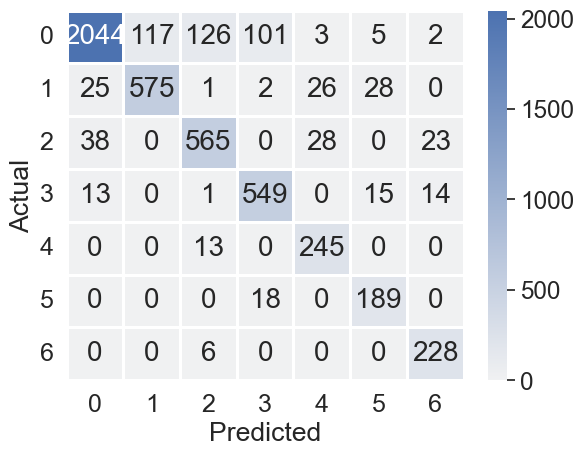

In [13]:
draw_matrix(evaluation['cm'], dataset.GRAPH_CLS.values(), fmt='d')

In [14]:
mean_embeds = [d.model_transform(model, key="embeds").mean(dim=0) for d in dataset_list_gt]

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


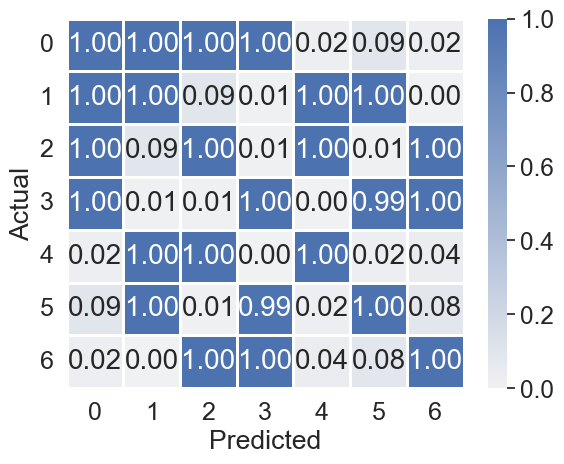

In [15]:
adj_ratio_mat, boundary_info = pairwise_boundary_analysis(model, dataset_list_pred)
draw_matrix(adj_ratio_mat, names=dataset.GRAPH_CLS.values(), fmt='.2f')

In [16]:
trainer = {}
sampler = {}

In [17]:
from gnn_boundary import Trainer

In [18]:
from utility_functions import *

In [19]:
def hyperparameterBoundary(max_nodes, lr, target_size, cls_1 = 0, cls_2 = 1):
    cls_1, cls_2 = cls_1, cls_2
    trainer[cls_1, cls_2] = Trainer(
        sampler=(s := GraphSampler(
            max_nodes=max_nodes,
            temperature=0.5,
            num_node_cls=3,#len(dataset.NODE_CLS),
            learn_node_feat=True
        )),
        discriminator=model,
        criterion=WeightedCriterion([
            dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
                classes=[cls_1, cls_2], alpha=1, beta=2
            ), weight=25),
            dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
            dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
            dict(key="logits", criterion=MeanPenalty(), weight=1),
            dict(key="omega", criterion=NormPenalty(order=1), weight=1),
            dict(key="omega", criterion=NormPenalty(order=2), weight=1),
            # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
            # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
            # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
            # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
            dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
        ]),
        optimizer=(o := torch.optim.SGD(s.parameters(), lr=lr)),
        scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
        dataset=dataset,
        budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
    )
    
    trainer[cls_1, cls_2].train(
        iterations=1000,
        target_probs={cls_1: (0.3, 0.7), cls_2: (0.3, 0.7)},
        target_size= target_size,
        w_budget_init=1,
        w_budget_inc=1.1,
        w_budget_dec=0.95,
        k_samples=16
    )

    explain_graph = trainer[cls_1, cls_2].evaluate(threshold=0.5, show=False)
    graph = dataset.convertNxToData(explain_graph)
    return graph
    


In [20]:
max_nodes_li = [10,15, 20, 25]
lr_li = [0.5,0.05, 0.005]
target_size_li = [15,25,30]

pairs = [(0,1),(0,2),(0,3),(1,4),(1,5),(2,4),(2,6),(3,5),(3,6)]

In [21]:
def indicator(prob, max_prob):
    if prob < max_prob:
        return 1
    else: 
        return 0

def criteria_function2(logits, all_probs,class_1, class_2):
    logits = [logit.item() for logit in logits]
    all_probs = [prob.item() for prob in all_probs]
    max_prob = max(all_probs)
    
    alpha = 1
    beta = 2
    sum_1 = 0
    sum_2 = 0
    for i in range(len(all_probs)):
        if i != class_1 and i != class_2:
            sum_1 += logits[i]*all_probs[i]**2
        else:
            sum_2 += logits[i]*(1-all_probs[i])**2*indicator(all_probs[i], max_prob)
    return beta * sum_1 -alpha* sum_2

In [22]:
#criteria_function = lambda x,y: (1-x)**2 + (1-y)**2
color_dict = {(0,0,1):"red",(0,1,0):"blue",(1,0,0):"black"}
for pair in pairs:
    class_1, class_2 = pair
    print("\n##################")
    print(f"class{class_1} class{class_2}")
    best_probs = None
    best_logits = None
    best_graph = None
    best_hyperparameters = (0,0,0)
    best_all_probs = None
    for max_nodes in max_nodes_li:
        for lr in lr_li:
            for target_size in target_size_li:
                try:
                    graph = hyperparameterBoundary(max_nodes = max_nodes,lr = lr, target_size = target_size, cls_1= class_1, cls_2= class_2)
                    probs = (model(graph)["probs"].squeeze()[class_1].item(),model(graph)["probs"].squeeze()[class_2].item())
                    print(f"MN: {max_nodes} LR: {lr} TS: {target_size} Probs: {probs}")

                    all_probs = model(graph)["probs"].squeeze()
                    logits = model(graph)["logits"].squeeze()
                    print(f"all probs: {all_probs}")
                    if best_probs == None or criteria_function2(best_logits, best_all_probs, class_1,class_2) > (loss := criteria_function2(logits, all_probs, class_1, class_2)):
                        best_probs = probs
                        best_graph = graph
                        best_hyperparameters = (max_nodes, lr, target_size)
                        best_all_probs = all_probs
                        best_logits = logits
                    print(f"loss {loss}")
                except Exception as e:
                    if str(e) == "Empty graph!":
                        print("Caught an Empty graph exception")
                        print(f"MN: {max_nodes} LR: {lr} TS: {target_size}")
    

    print("********best result*********")
    print(best_probs)
    print(best_hyperparameters)
    print(best_all_probs)
    printGraph(best_graph, f"./images/duo_class_sec_{class_1}_class_{class_2}", clear_figure = True, color_dict = color_dict)



##################
class0 class1


100%|██████████| 1000/1000 [00:22<00:00, 43.89it/s]


MN: 10 LR: 0.5 TS: 15 Probs: (0.07188600301742554, 0.21932868659496307)
all probs: tensor([0.0719, 0.2193, 0.0064, 0.1966, 0.0105, 0.4900, 0.0052],
       grad_fn=<SqueezeBackward0>)


 14%|█▍        | 141/1000 [00:03<00:22, 38.76it/s]


MN: 10 LR: 0.5 TS: 25 Probs: (0.18084120750427246, 0.7175829410552979)
all probs: tensor([1.8084e-01, 7.1758e-01, 1.9253e-02, 1.8152e-03, 4.4461e-02, 3.5823e-02,
        2.2323e-04], grad_fn=<SqueezeBackward0>)
loss 1.0706402817846863


  2%|▏         | 18/1000 [00:00<00:23, 41.95it/s]


MN: 10 LR: 0.5 TS: 30 Probs: (0.1559060513973236, 0.7425591945648193)
all probs: tensor([1.5591e-01, 7.4256e-01, 1.6650e-02, 1.2355e-03, 4.8300e-02, 3.5185e-02,
        1.6409e-04], grad_fn=<SqueezeBackward0>)
loss 1.3280046633934075


 88%|████████▊ | 878/1000 [00:22<00:03, 39.09it/s]


MN: 10 LR: 0.05 TS: 15 Probs: (0.06147034093737602, 0.20409147441387177)
all probs: tensor([0.0615, 0.2041, 0.0068, 0.1859, 0.0125, 0.5231, 0.0062],
       grad_fn=<SqueezeBackward0>)
loss 1.740552379412466


 48%|████▊     | 476/1000 [00:12<00:14, 37.26it/s]


MN: 10 LR: 0.05 TS: 25 Probs: (0.22316992282867432, 0.6624194979667664)
all probs: tensor([2.2317e-01, 6.6242e-01, 2.8411e-02, 3.2826e-03, 4.5799e-02, 3.6483e-02,
        4.3582e-04], grad_fn=<SqueezeBackward0>)
loss 0.7014833432903218


100%|██████████| 1000/1000 [00:24<00:00, 40.26it/s]


MN: 10 LR: 0.05 TS: 30 Probs: (0.20710110664367676, 0.6884289383888245)
all probs: tensor([2.0710e-01, 6.8843e-01, 2.3432e-02, 2.4684e-03, 4.3425e-02, 3.4839e-02,
        3.0610e-04], grad_fn=<SqueezeBackward0>)
loss 0.8383794221945634


100%|██████████| 1000/1000 [00:23<00:00, 42.22it/s]


MN: 10 LR: 0.005 TS: 15 Probs: (0.27150723338127136, 0.5552735328674316)
all probs: tensor([0.2715, 0.5553, 0.0626, 0.0072, 0.0640, 0.0379, 0.0015],
       grad_fn=<SqueezeBackward0>)
loss 0.30846257645999237


100%|██████████| 1000/1000 [00:25<00:00, 39.47it/s]


MN: 10 LR: 0.005 TS: 25 Probs: (0.06413926929235458, 0.2086663842201233)
all probs: tensor([0.0641, 0.2087, 0.0063, 0.1890, 0.0113, 0.5150, 0.0056],
       grad_fn=<SqueezeBackward0>)
loss 1.67127966631746


100%|██████████| 1000/1000 [00:23<00:00, 43.09it/s]


MN: 10 LR: 0.005 TS: 30 Probs: (0.1787082999944687, 0.7200686931610107)
all probs: tensor([1.7871e-01, 7.2007e-01, 1.9426e-02, 1.6462e-03, 4.5745e-02, 3.4194e-02,
        2.1159e-04], grad_fn=<SqueezeBackward0>)
loss 1.091360438039023


100%|██████████| 1000/1000 [00:24<00:00, 40.21it/s]


MN: 15 LR: 0.5 TS: 15 Probs: (0.1159137636423111, 0.7884006500244141)
all probs: tensor([1.1591e-01, 7.8840e-01, 1.1389e-02, 5.4600e-04, 5.1484e-02, 3.2189e-02,
        7.7488e-05], grad_fn=<SqueezeBackward0>)
loss 1.8675616651566633


 10%|█         | 105/1000 [00:02<00:23, 37.93it/s]


MN: 15 LR: 0.5 TS: 25 Probs: (0.11311046034097672, 0.8335839509963989)
all probs: tensor([1.1311e-01, 8.3358e-01, 4.8732e-03, 3.2592e-04, 2.4011e-02, 2.4074e-02,
        2.1270e-05], grad_fn=<SqueezeBackward0>)
loss 1.982726055706889


  5%|▌         | 51/1000 [00:01<00:25, 37.56it/s]


MN: 15 LR: 0.5 TS: 30 Probs: (0.13207103312015533, 0.8191554546356201)
all probs: tensor([1.3207e-01, 8.1916e-01, 4.7405e-03, 4.8022e-04, 1.8772e-02, 2.4757e-02,
        2.3905e-05], grad_fn=<SqueezeBackward0>)
loss 1.7079083785658733


100%|██████████| 1000/1000 [00:23<00:00, 42.55it/s]


MN: 15 LR: 0.05 TS: 15 Probs: (0.13918957114219666, 0.7657327055931091)
all probs: tensor([1.3919e-01, 7.6573e-01, 1.3812e-02, 8.3249e-04, 4.7913e-02, 3.2410e-02,
        1.1056e-04], grad_fn=<SqueezeBackward0>)
loss 1.5398943728705023


100%|██████████| 1000/1000 [00:27<00:00, 36.46it/s]


MN: 15 LR: 0.05 TS: 25 Probs: (0.017999902367591858, 0.11539388447999954)
all probs: tensor([0.0180, 0.1154, 0.0016, 0.1131, 0.0066, 0.7427, 0.0027],
       grad_fn=<SqueezeBackward0>)
loss 4.1626261283501265


100%|██████████| 1000/1000 [00:24<00:00, 40.56it/s]


MN: 15 LR: 0.05 TS: 30 Probs: (0.21292878687381744, 0.6667948961257935)
all probs: tensor([2.1293e-01, 6.6679e-01, 2.9733e-02, 2.8712e-03, 5.1331e-02, 3.5908e-02,
        4.3260e-04], grad_fn=<SqueezeBackward0>)
loss 0.7670640379554889


100%|██████████| 1000/1000 [00:23<00:00, 43.06it/s]


Caught an Empty graph exception
MN: 15 LR: 0.005 TS: 15


100%|██████████| 1000/1000 [00:23<00:00, 42.88it/s]


MN: 15 LR: 0.005 TS: 25 Probs: (0.27150723338127136, 0.5552735328674316)
all probs: tensor([0.2715, 0.5553, 0.0626, 0.0072, 0.0640, 0.0379, 0.0015],
       grad_fn=<SqueezeBackward0>)
loss 0.30846257645999237


100%|██████████| 1000/1000 [00:24<00:00, 41.11it/s]


MN: 15 LR: 0.005 TS: 30 Probs: (0.23817245662212372, 0.614998459815979)
all probs: tensor([0.2382, 0.6150, 0.0441, 0.0044, 0.0602, 0.0373, 0.0008],
       grad_fn=<SqueezeBackward0>)
loss 0.5455659691334278


100%|██████████| 1000/1000 [00:26<00:00, 38.05it/s]


MN: 20 LR: 0.5 TS: 15 Probs: (0.047833558171987534, 0.1994151771068573)
all probs: tensor([4.7834e-02, 1.9942e-01, 3.7151e-04, 1.7435e-01, 8.6560e-04, 5.7684e-01,
        3.1567e-04], grad_fn=<SqueezeBackward0>)
loss 2.2296521896486836


 16%|█▌        | 161/1000 [00:04<00:23, 35.85it/s]


MN: 20 LR: 0.5 TS: 25 Probs: (0.1365378201007843, 0.0009821208659559488)
all probs: tensor([1.3654e-01, 9.8212e-04, 8.3642e-04, 8.5558e-01, 2.5398e-05, 5.0306e-03,
        1.0063e-03], grad_fn=<SqueezeBackward0>)
loss 8.22670638164936


 13%|█▎        | 129/1000 [00:03<00:24, 35.05it/s]


MN: 20 LR: 0.5 TS: 30 Probs: (0.021163655444979668, 0.1239003986120224)
all probs: tensor([2.1164e-02, 1.2390e-01, 1.6863e-01, 1.4859e-05, 6.8436e-01, 1.5424e-03,
        3.9016e-04], grad_fn=<SqueezeBackward0>)
loss 3.644154738313774


100%|██████████| 1000/1000 [00:27<00:00, 36.00it/s]


MN: 20 LR: 0.05 TS: 15 Probs: (0.11183161288499832, 0.8141281008720398)
all probs: tensor([1.1183e-01, 8.1413e-01, 7.3971e-03, 4.4345e-04, 3.6152e-02, 3.0005e-02,
        4.2838e-05], grad_fn=<SqueezeBackward0>)
loss 1.9705425231023581


100%|██████████| 1000/1000 [00:25<00:00, 39.61it/s]


MN: 20 LR: 0.05 TS: 25 Probs: (0.09828358143568039, 0.8290008902549744)
all probs: tensor([9.8284e-02, 8.2900e-01, 6.1385e-03, 3.3771e-04, 3.6019e-02, 3.0188e-02,
        3.2161e-05], grad_fn=<SqueezeBackward0>)
loss 2.2075412084409285


100%|██████████| 1000/1000 [00:26<00:00, 38.11it/s]


MN: 20 LR: 0.05 TS: 30 Probs: (0.061307646334171295, 0.20188085734844208)
all probs: tensor([0.0613, 0.2019, 0.0085, 0.1847, 0.0155, 0.5203, 0.0079],
       grad_fn=<SqueezeBackward0>)
loss 1.7306461539927478


100%|██████████| 1000/1000 [00:25<00:00, 38.86it/s]


MN: 20 LR: 0.005 TS: 15 Probs: (0.2046547681093216, 0.6695070266723633)
all probs: tensor([2.0465e-01, 6.6951e-01, 3.0602e-02, 2.6625e-03, 5.5858e-02, 3.6278e-02,
        4.3780e-04], grad_fn=<SqueezeBackward0>)
loss 0.8221473617488432


100%|██████████| 1000/1000 [00:26<00:00, 38.45it/s]


MN: 20 LR: 0.005 TS: 25 Probs: (0.09781040251255035, 0.23797570168972015)
all probs: tensor([0.0978, 0.2380, 0.0164, 0.2111, 0.0206, 0.4044, 0.0117],
       grad_fn=<SqueezeBackward0>)
loss 0.9296960583319125


100%|██████████| 1000/1000 [00:26<00:00, 38.08it/s]


MN: 20 LR: 0.005 TS: 30 Probs: (0.08663098514080048, 0.22662079334259033)
all probs: tensor([0.0866, 0.2266, 0.0165, 0.2034, 0.0228, 0.4312, 0.0128],
       grad_fn=<SqueezeBackward0>)
loss 1.1105327051683174


100%|██████████| 1000/1000 [00:29<00:00, 34.24it/s]


MN: 25 LR: 0.5 TS: 15 Probs: (0.09095250070095062, 0.8920159339904785)
all probs: tensor([9.0953e-02, 8.9202e-01, 7.2221e-04, 7.3055e-05, 4.9413e-03, 1.1294e-02,
        1.0441e-06], grad_fn=<SqueezeBackward0>)
loss 2.425726606517749


 13%|█▎        | 130/1000 [00:04<00:28, 30.20it/s]


MN: 25 LR: 0.5 TS: 25 Probs: (0.008172266185283661, 0.07988356053829193)
all probs: tensor([8.1723e-03, 7.9884e-02, 1.4893e-04, 7.9062e-02, 1.0186e-03, 8.3140e-01,
        3.1567e-04], grad_fn=<SqueezeBackward0>)
loss 5.788982308663515


 52%|█████▏    | 517/1000 [00:15<00:14, 32.54it/s]


MN: 25 LR: 0.5 TS: 30 Probs: (0.06776103377342224, 0.9113141894340515)
all probs: tensor([6.7761e-02, 9.1131e-01, 6.2187e-04, 5.2923e-05, 6.3248e-03, 1.3924e-02,
        9.2080e-07], grad_fn=<SqueezeBackward0>)
loss 2.95694542036414


100%|██████████| 1000/1000 [00:29<00:00, 33.43it/s]


MN: 25 LR: 0.05 TS: 15 Probs: (0.11488790065050125, 0.7978940010070801)
all probs: tensor([1.1489e-01, 7.9789e-01, 9.5816e-03, 5.4141e-04, 4.4327e-02, 3.2704e-02,
        6.4388e-05], grad_fn=<SqueezeBackward0>)
loss 1.8990690805073653


100%|██████████| 1000/1000 [00:43<00:00, 22.81it/s]


MN: 25 LR: 0.05 TS: 25 Probs: (0.03866634517908096, 0.1654442399740219)
all probs: tensor([3.8666e-02, 1.6544e-01, 2.1213e-01, 1.2031e-04, 5.7745e-01, 4.7529e-03,
        1.4414e-03], grad_fn=<SqueezeBackward0>)
loss 2.4663920920103823


100%|██████████| 1000/1000 [00:36<00:00, 27.25it/s]


MN: 25 LR: 0.05 TS: 30 Probs: (0.16822348535060883, 0.7200366854667664)
all probs: tensor([1.6822e-01, 7.2004e-01, 2.1048e-02, 1.5219e-03, 5.3579e-02, 3.5360e-02,
        2.3043e-04], grad_fn=<SqueezeBackward0>)
loss 1.1774958604962946


100%|██████████| 1000/1000 [00:30<00:00, 32.37it/s]


MN: 25 LR: 0.005 TS: 15 Probs: (0.23817245662212372, 0.614998459815979)
all probs: tensor([0.2382, 0.6150, 0.0441, 0.0044, 0.0602, 0.0373, 0.0008],
       grad_fn=<SqueezeBackward0>)
loss 0.5455659691334278


100%|██████████| 1000/1000 [00:28<00:00, 34.84it/s]


Caught an Empty graph exception
MN: 25 LR: 0.005 TS: 25


100%|██████████| 1000/1000 [00:30<00:00, 32.36it/s]


MN: 25 LR: 0.005 TS: 30 Probs: (0.27150723338127136, 0.5552735328674316)
all probs: tensor([0.2715, 0.5553, 0.0626, 0.0072, 0.0640, 0.0379, 0.0015],
       grad_fn=<SqueezeBackward0>)
loss 0.30846257645999237
********best result*********
(0.27150723338127136, 0.5552735328674316)
(10, 0.005, 15)
tensor([0.2715, 0.5553, 0.0626, 0.0072, 0.0640, 0.0379, 0.0015],
       grad_fn=<SqueezeBackward0>)

##################
class0 class2


100%|██████████| 1000/1000 [00:21<00:00, 45.73it/s]


MN: 10 LR: 0.5 TS: 15 Probs: (0.2424556463956833, 0.012156971730291843)
all probs: tensor([2.4246e-01, 6.9804e-01, 1.2157e-02, 2.3214e-03, 1.8569e-02, 2.6334e-02,
        1.2286e-04], grad_fn=<SqueezeBackward0>)
loss 0.30846257645999237


100%|██████████| 1000/1000 [00:22<00:00, 44.00it/s]


MN: 10 LR: 0.5 TS: 25 Probs: (0.17815396189689636, 0.025455422699451447)
all probs: tensor([1.7815e-01, 6.9851e-01, 2.5455e-02, 1.9471e-03, 5.8206e-02, 3.7401e-02,
        3.2319e-04], grad_fn=<SqueezeBackward0>)
loss 4.202409218168649


100%|██████████| 1000/1000 [00:22<00:00, 44.03it/s]


MN: 10 LR: 0.5 TS: 30 Probs: (0.04974659904837608, 0.0027333360631018877)
all probs: tensor([0.0497, 0.1913, 0.0027, 0.1742, 0.0060, 0.5733, 0.0027],
       grad_fn=<SqueezeBackward0>)
loss 6.448011750442283


 12%|█▏        | 121/1000 [00:02<00:21, 41.58it/s]


MN: 10 LR: 0.05 TS: 15 Probs: (0.030460922047495842, 0.19384980201721191)
all probs: tensor([3.0461e-02, 1.4879e-01, 1.9385e-01, 5.6515e-06, 6.2611e-01, 6.3433e-04,
        1.5526e-04], grad_fn=<SqueezeBackward0>)
loss 2.719092816081411


100%|██████████| 1000/1000 [00:21<00:00, 46.21it/s]


MN: 10 LR: 0.05 TS: 25 Probs: (0.26390981674194336, 0.6018990278244019)
all probs: tensor([0.2639, 0.0321, 0.6019, 0.0040, 0.0852, 0.0016, 0.0113],
       grad_fn=<SqueezeBackward0>)
loss 0.3082387919227127


100%|██████████| 1000/1000 [00:24<00:00, 41.57it/s]


MN: 10 LR: 0.05 TS: 30 Probs: (0.28524667024612427, 0.05339531600475311)
all probs: tensor([0.2852, 0.0210, 0.0534, 0.5702, 0.0052, 0.0308, 0.0342],
       grad_fn=<SqueezeBackward0>)
loss 2.4763385247806724


100%|██████████| 1000/1000 [00:22<00:00, 44.41it/s]


MN: 10 LR: 0.005 TS: 15 Probs: (0.23860320448875427, 0.6560200452804565)
all probs: tensor([0.2386, 0.0194, 0.6560, 0.0018, 0.0759, 0.0007, 0.0076],
       grad_fn=<SqueezeBackward0>)
loss 0.465108205101949


100%|██████████| 1000/1000 [00:24<00:00, 40.53it/s]


MN: 10 LR: 0.005 TS: 25 Probs: (0.26390981674194336, 0.6018990278244019)
all probs: tensor([0.2639, 0.0321, 0.6019, 0.0040, 0.0852, 0.0016, 0.0113],
       grad_fn=<SqueezeBackward0>)
loss 0.3082387919227127


100%|██████████| 1000/1000 [00:22<00:00, 44.73it/s]


Caught an Empty graph exception
MN: 10 LR: 0.005 TS: 30


 10%|█         | 102/1000 [00:02<00:21, 41.30it/s]


MN: 15 LR: 0.5 TS: 15 Probs: (0.0052490802481770515, 0.05510485917329788)
all probs: tensor([0.0052, 0.0374, 0.0551, 0.0419, 0.2838, 0.4030, 0.1736],
       grad_fn=<SqueezeBackward0>)
loss 3.5835813775027248


  2%|▏         | 24/1000 [00:00<00:28, 34.21it/s]


MN: 15 LR: 0.5 TS: 25 Probs: (0.07549992948770523, 0.2607629597187042)
all probs: tensor([7.5500e-02, 2.2108e-01, 2.6076e-01, 9.5302e-05, 4.3917e-01, 2.5656e-03,
        8.1748e-04], grad_fn=<SqueezeBackward0>)
loss 1.202663331156315


100%|██████████| 1000/1000 [00:29<00:00, 33.87it/s]


MN: 15 LR: 0.5 TS: 30 Probs: (0.19423140585422516, 0.016137620434165)
all probs: tensor([1.9423e-01, 6.0817e-04, 1.6138e-02, 7.7045e-01, 2.2015e-04, 1.9409e-03,
        1.6414e-02], grad_fn=<SqueezeBackward0>)
loss 4.69195067002433


 49%|████▊     | 486/1000 [00:11<00:12, 42.58it/s]


MN: 15 LR: 0.05 TS: 15 Probs: (0.02749445289373398, 0.1870202124118805)
all probs: tensor([2.7494e-02, 1.4107e-01, 1.8702e-01, 2.7683e-05, 6.4177e-01, 2.0673e-03,
        5.5505e-04], grad_fn=<SqueezeBackward0>)
loss 2.8993717260235727


 24%|██▍       | 242/1000 [00:06<00:18, 39.90it/s]


MN: 15 LR: 0.05 TS: 25 Probs: (0.01940751262009144, 0.16299539804458618)
all probs: tensor([1.9408e-02, 1.1831e-01, 1.6300e-01, 3.3251e-05, 6.9565e-01, 2.8535e-03,
        7.5486e-04], grad_fn=<SqueezeBackward0>)
loss 3.547170224665276


100%|██████████| 1000/1000 [00:23<00:00, 42.85it/s]


MN: 15 LR: 0.05 TS: 30 Probs: (0.26007503271102905, 0.05110790207982063)
all probs: tensor([0.2601, 0.5858, 0.0511, 0.0058, 0.0588, 0.0373, 0.0011],
       grad_fn=<SqueezeBackward0>)
loss 2.6086109062140834


100%|██████████| 1000/1000 [00:22<00:00, 44.68it/s]


MN: 15 LR: 0.005 TS: 15 Probs: (0.26390981674194336, 0.6018990278244019)
all probs: tensor([0.2639, 0.0321, 0.6019, 0.0040, 0.0852, 0.0016, 0.0113],
       grad_fn=<SqueezeBackward0>)
loss 0.3082387919227127


100%|██████████| 1000/1000 [00:22<00:00, 44.51it/s]


MN: 15 LR: 0.005 TS: 25 Probs: (0.18844853341579437, 0.7604679465293884)
all probs: tensor([1.8845e-01, 4.4650e-03, 7.6047e-01, 2.8786e-04, 4.3612e-02, 6.2000e-05,
        2.6569e-03], grad_fn=<SqueezeBackward0>)
loss 0.837573378518964


100%|██████████| 1000/1000 [00:22<00:00, 43.71it/s]


Caught an Empty graph exception
MN: 15 LR: 0.005 TS: 30


100%|██████████| 1000/1000 [00:26<00:00, 37.84it/s]


MN: 20 LR: 0.5 TS: 15 Probs: (0.02138119749724865, 0.0007005651714280248)
all probs: tensor([2.1381e-02, 1.3011e-01, 7.0057e-04, 1.2351e-01, 2.6816e-03, 7.2062e-01,
        1.0040e-03], grad_fn=<SqueezeBackward0>)
loss 9.133526220775503


 10%|█         | 102/1000 [00:03<00:29, 29.94it/s]


MN: 20 LR: 0.5 TS: 25 Probs: (0.017652425915002823, 0.15635477006435394)
all probs: tensor([1.7652e-02, 1.1307e-01, 1.5635e-01, 6.0522e-06, 7.1180e-01, 9.0160e-04,
        2.1259e-04], grad_fn=<SqueezeBackward0>)
loss 3.7411431393866303


100%|██████████| 1000/1000 [00:25<00:00, 38.97it/s]


MN: 20 LR: 0.5 TS: 30 Probs: (0.008546531200408936, 0.1142667829990387)
all probs: tensor([8.5465e-03, 7.6814e-02, 1.1427e-01, 4.5511e-06, 7.9907e-01, 1.0619e-03,
        2.3413e-04], grad_fn=<SqueezeBackward0>)
loss 5.15461519831333


100%|██████████| 1000/1000 [00:24<00:00, 40.88it/s]


MN: 20 LR: 0.05 TS: 15 Probs: (0.024395795539021492, 0.00016483452054671943)
all probs: tensor([2.4396e-02, 1.4572e-01, 1.6483e-04, 1.3254e-01, 5.9973e-04, 6.9638e-01,
        1.9494e-04], grad_fn=<SqueezeBackward0>)
loss 10.414363303785958


 36%|███▌      | 359/1000 [00:10<00:17, 35.73it/s]


MN: 20 LR: 0.05 TS: 25 Probs: (0.044130582362413406, 0.25985080003738403)
all probs: tensor([4.4131e-02, 2.4577e-05, 2.5985e-01, 2.2658e-01, 1.1773e-03, 1.2762e-04,
        4.6811e-01], grad_fn=<SqueezeBackward0>)
loss 1.7725149010429408


  6%|▋         | 64/1000 [00:01<00:28, 33.12it/s]


MN: 20 LR: 0.05 TS: 30 Probs: (0.11241117864847183, 0.2841269373893738)
all probs: tensor([0.1124, 0.2535, 0.2841, 0.0004, 0.3433, 0.0046, 0.0017],
       grad_fn=<SqueezeBackward0>)
loss 0.6508813043303162


100%|██████████| 1000/1000 [00:25<00:00, 39.09it/s]


MN: 20 LR: 0.005 TS: 15 Probs: (0.11014722287654877, 0.30627912282943726)
all probs: tensor([0.1101, 0.0045, 0.3063, 0.2621, 0.0215, 0.0092, 0.2861],
       grad_fn=<SqueezeBackward0>)
loss 0.6887491047030166


100%|██████████| 1000/1000 [00:24<00:00, 40.68it/s]


MN: 20 LR: 0.005 TS: 25 Probs: (0.22770993411540985, 0.6908122301101685)
all probs: tensor([2.2771e-01, 1.2218e-02, 6.9081e-01, 1.0903e-03, 6.2248e-02, 3.2568e-04,
        5.5954e-03], grad_fn=<SqueezeBackward0>)
loss 0.5526082943137091


100%|██████████| 1000/1000 [00:23<00:00, 41.76it/s]


MN: 20 LR: 0.005 TS: 30 Probs: (0.23860320448875427, 0.6560200452804565)
all probs: tensor([0.2386, 0.0194, 0.6560, 0.0018, 0.0759, 0.0007, 0.0076],
       grad_fn=<SqueezeBackward0>)
loss 0.465108205101949


  3%|▎         | 31/1000 [00:02<01:05, 14.86it/s]


MN: 25 LR: 0.5 TS: 15 Probs: (0.004884291440248489, 0.05328430235385895)
all probs: tensor([0.0049, 0.0359, 0.0533, 0.0404, 0.2856, 0.4061, 0.1738],
       grad_fn=<SqueezeBackward0>)
loss 3.6704198839653324


  2%|▏         | 23/1000 [00:01<01:01, 15.80it/s]


MN: 25 LR: 0.5 TS: 25 Probs: (0.03903579339385033, 0.003793019335716963)
all probs: tensor([0.0390, 0.1681, 0.0038, 0.1574, 0.0096, 0.6177, 0.0044],
       grad_fn=<SqueezeBackward0>)
loss 6.436556967624607


 34%|███▍      | 342/1000 [00:10<00:20, 32.46it/s]


MN: 25 LR: 0.5 TS: 30 Probs: (0.002202101517468691, 0.03648640587925911)
all probs: tensor([0.0022, 0.0228, 0.0365, 0.0271, 0.3024, 0.4355, 0.1735],
       grad_fn=<SqueezeBackward0>)
loss 4.62440965515627


 28%|██▊       | 284/1000 [00:08<00:21, 32.94it/s]


MN: 25 LR: 0.05 TS: 15 Probs: (0.03361232578754425, 0.20175978541374207)
all probs: tensor([3.3612e-02, 1.5512e-01, 2.0176e-01, 7.2608e-05, 6.0476e-01, 3.6271e-03,
        1.0525e-03], grad_fn=<SqueezeBackward0>)
loss 2.5283374550159787


 12%|█▏        | 115/1000 [00:03<00:28, 30.77it/s]


MN: 25 LR: 0.05 TS: 25 Probs: (0.01097920723259449, 0.07708457857370377)
all probs: tensor([0.0110, 0.0561, 0.0771, 0.0599, 0.2609, 0.3661, 0.1689],
       grad_fn=<SqueezeBackward0>)
loss 2.6909115450272014


 16%|█▌        | 160/1000 [00:04<00:26, 32.19it/s]


MN: 25 LR: 0.05 TS: 30 Probs: (0.0414993092417717, 0.255555123090744)
all probs: tensor([4.1499e-02, 1.5505e-05, 2.5556e-01, 2.2346e-01, 8.8777e-04, 8.5118e-05,
        4.7850e-01], grad_fn=<SqueezeBackward0>)
loss 1.8546262497208765


100%|██████████| 1000/1000 [00:28<00:00, 35.62it/s]


Caught an Empty graph exception
MN: 25 LR: 0.005 TS: 15


100%|██████████| 1000/1000 [00:28<00:00, 34.88it/s]


MN: 25 LR: 0.005 TS: 25 Probs: (0.26390981674194336, 0.6018990278244019)
all probs: tensor([0.2639, 0.0321, 0.6019, 0.0040, 0.0852, 0.0016, 0.0113],
       grad_fn=<SqueezeBackward0>)
loss 0.3082387919227127


100%|██████████| 1000/1000 [00:27<00:00, 36.01it/s]


Caught an Empty graph exception
MN: 25 LR: 0.005 TS: 30
********best result*********
(0.26390981674194336, 0.6018990278244019)
(10, 0.05, 25)
tensor([0.2639, 0.0321, 0.6019, 0.0040, 0.0852, 0.0016, 0.0113],
       grad_fn=<SqueezeBackward0>)

##################
class0 class3


  0%|          | 5/1000 [00:00<00:28, 35.15it/s]


MN: 10 LR: 0.5 TS: 15 Probs: (0.1650332510471344, 0.8152665495872498)
all probs: tensor([1.6503e-01, 1.7211e-04, 8.6975e-03, 8.1527e-01, 5.9311e-05, 6.9739e-04,
        1.0074e-02], grad_fn=<SqueezeBackward0>)
loss 0.3082387919227127


  1%|          | 7/1000 [00:00<00:25, 39.55it/s]


MN: 10 LR: 0.5 TS: 25 Probs: (0.17132386565208435, 0.7903229594230652)
all probs: tensor([1.7132e-01, 3.8785e-04, 1.6737e-02, 7.9032e-01, 1.9407e-04, 1.5000e-03,
        1.9534e-02], grad_fn=<SqueezeBackward0>)
loss 1.15627001560922


  1%|          | 9/1000 [00:00<00:22, 43.81it/s]


MN: 10 LR: 0.5 TS: 30 Probs: (0.18658818304538727, 0.7762442827224731)
all probs: tensor([1.8659e-01, 5.4132e-04, 1.6739e-02, 7.7624e-01, 2.2108e-04, 1.8384e-03,
        1.7828e-02], grad_fn=<SqueezeBackward0>)
loss 1.0330398831621879


  2%|▏         | 24/1000 [00:00<00:20, 47.47it/s]


MN: 10 LR: 0.05 TS: 15 Probs: (0.21884630620479584, 0.7169865965843201)
all probs: tensor([0.2188, 0.0020, 0.0293, 0.7170, 0.0008, 0.0052, 0.0268],
       grad_fn=<SqueezeBackward0>)
loss 0.7757822150335156


  0%|          | 5/1000 [00:00<00:25, 38.33it/s]


MN: 10 LR: 0.05 TS: 25 Probs: (0.0989527553319931, 0.21837836503982544)
all probs: tensor([0.0990, 0.2536, 0.0041, 0.2184, 0.0054, 0.4169, 0.0026],
       grad_fn=<SqueezeBackward0>)
loss 1.0884797853831123


  4%|▎         | 36/1000 [00:00<00:20, 48.11it/s]


MN: 10 LR: 0.05 TS: 30 Probs: (0.09761856496334076, 0.214689239859581)
all probs: tensor([0.0976, 0.2447, 0.0093, 0.2147, 0.0119, 0.4154, 0.0063],
       grad_fn=<SqueezeBackward0>)
loss 1.0673151028321817


  6%|▌         | 55/1000 [00:01<00:19, 47.67it/s]


MN: 10 LR: 0.005 TS: 15 Probs: (0.054288510233163834, 0.17972473800182343)
all probs: tensor([0.0543, 0.1982, 0.0032, 0.1797, 0.0066, 0.5549, 0.0030],
       grad_fn=<SqueezeBackward0>)
loss 2.0653300812268878


  5%|▌         | 52/1000 [00:01<00:19, 47.63it/s]


MN: 10 LR: 0.005 TS: 25 Probs: (0.06236525624990463, 0.1870223581790924)
all probs: tensor([0.0624, 0.2058, 0.0065, 0.1870, 0.0119, 0.5206, 0.0059],
       grad_fn=<SqueezeBackward0>)
loss 1.7908350916635836


 44%|████▍     | 440/1000 [00:10<00:12, 43.91it/s]


MN: 10 LR: 0.005 TS: 30 Probs: (0.2043684720993042, 0.7453688383102417)
all probs: tensor([2.0437e-01, 1.0667e-03, 2.3041e-02, 7.4537e-01, 4.3776e-04, 3.1297e-03,
        2.2588e-02], grad_fn=<SqueezeBackward0>)
loss 0.8866550902409287


  0%|          | 1/1000 [00:00<02:19,  7.16it/s]


MN: 15 LR: 0.5 TS: 15 Probs: (0.048533327877521515, 0.17323867976665497)
all probs: tensor([0.0485, 0.1913, 0.0019, 0.1732, 0.0043, 0.5789, 0.0018],
       grad_fn=<SqueezeBackward0>)
loss 2.281724510327024


  0%|          | 1/1000 [00:00<02:08,  7.77it/s]


MN: 15 LR: 0.5 TS: 25 Probs: (0.02960222400724888, 0.1415562927722931)
all probs: tensor([0.0296, 0.1504, 0.0016, 0.1416, 0.0050, 0.6698, 0.0021],
       grad_fn=<SqueezeBackward0>)
loss 3.208014106221076


  0%|          | 4/1000 [00:00<00:49, 20.09it/s]


MN: 15 LR: 0.5 TS: 30 Probs: (0.05420612916350365, 0.17780493199825287)
all probs: tensor([0.0542, 0.1935, 0.0061, 0.1778, 0.0122, 0.5503, 0.0060],
       grad_fn=<SqueezeBackward0>)
loss 2.03313638119511


  2%|▏         | 24/1000 [00:00<00:25, 38.79it/s]


MN: 15 LR: 0.05 TS: 15 Probs: (0.2039804756641388, 0.7485213279724121)
all probs: tensor([2.0398e-01, 1.0442e-03, 2.1699e-02, 7.4852e-01, 4.0758e-04, 3.0785e-03,
        2.1268e-02], grad_fn=<SqueezeBackward0>)
loss 0.8938110997101327


  0%|          | 3/1000 [00:00<00:57, 17.34it/s]


MN: 15 LR: 0.05 TS: 25 Probs: (0.023636508733034134, 0.1824357956647873)
all probs: tensor([2.3637e-02, 3.0461e-05, 2.1531e-01, 1.8244e-01, 2.1686e-03, 2.7303e-04,
        5.7615e-01], grad_fn=<SqueezeBackward0>)
loss 2.879156920453673


  2%|▏         | 18/1000 [00:00<00:27, 35.57it/s]


MN: 15 LR: 0.05 TS: 30 Probs: (0.23015375435352325, 0.7377947568893433)
all probs: tensor([2.3015e-01, 1.1601e-03, 1.5132e-02, 7.3779e-01, 2.6313e-04, 2.8232e-03,
        1.2673e-02], grad_fn=<SqueezeBackward0>)
loss 0.74260531093242


 93%|█████████▎| 928/1000 [00:21<00:01, 43.95it/s]


MN: 15 LR: 0.005 TS: 15 Probs: (0.17133259773254395, 0.7911101579666138)
all probs: tensor([1.7133e-01, 4.0039e-04, 1.6348e-02, 7.9111e-01, 1.9402e-04, 1.5495e-03,
        1.9065e-02], grad_fn=<SqueezeBackward0>)
loss 1.1584785176877057


  4%|▍         | 45/1000 [00:01<00:22, 42.07it/s]


MN: 15 LR: 0.005 TS: 25 Probs: (0.16295696794986725, 0.8229458332061768)
all probs: tensor([1.6296e-01, 1.1634e-04, 6.2903e-03, 8.2295e-01, 3.2913e-05, 4.7519e-04,
        7.1824e-03], grad_fn=<SqueezeBackward0>)
loss 1.2549920216896322


  6%|▌         | 62/1000 [00:01<00:21, 43.21it/s]


MN: 15 LR: 0.005 TS: 30 Probs: (0.07375001907348633, 0.1982906013727188)
all probs: tensor([0.0738, 0.2216, 0.0065, 0.1983, 0.0104, 0.4842, 0.0052],
       grad_fn=<SqueezeBackward0>)
loss 1.5175928944898636


  0%|          | 1/1000 [00:00<05:32,  3.00it/s]


MN: 20 LR: 0.5 TS: 15 Probs: (0.1734096258878708, 0.7998499870300293)
all probs: tensor([1.7341e-01, 2.8871e-04, 1.1876e-02, 7.9985e-01, 1.1009e-04, 1.0936e-03,
        1.3372e-02], grad_fn=<SqueezeBackward0>)
loss 1.151781159321531


  1%|▏         | 13/1000 [00:00<00:45, 21.90it/s]


MN: 20 LR: 0.5 TS: 25 Probs: (0.014525443315505981, 0.10395027697086334)
all probs: tensor([1.4525e-02, 1.0817e-01, 2.9958e-04, 1.0395e-01, 1.4629e-03, 7.7110e-01,
        4.9543e-04], grad_fn=<SqueezeBackward0>)
loss 4.641084919708758


  1%|          | 11/1000 [00:00<00:50, 19.59it/s]


MN: 20 LR: 0.5 TS: 30 Probs: (0.2024906873703003, 0.7494515776634216)
all probs: tensor([2.0249e-01, 1.0472e-03, 2.1860e-02, 7.4945e-01, 4.1529e-04, 3.1232e-03,
        2.1613e-02], grad_fn=<SqueezeBackward0>)
loss 0.904078738578696


  1%|          | 9/1000 [00:00<00:56, 17.47it/s]


MN: 20 LR: 0.05 TS: 15 Probs: (0.08105939626693726, 0.25716501474380493)
all probs: tensor([0.0811, 0.0006, 0.2979, 0.2572, 0.0068, 0.0017, 0.3549],
       grad_fn=<SqueezeBackward0>)
loss 1.0793771121381284


  0%|          | 4/1000 [00:00<01:37, 10.19it/s]


MN: 20 LR: 0.05 TS: 25 Probs: (0.1256919950246811, 0.8655454516410828)
all probs: tensor([1.2569e-01, 2.5359e-05, 3.5480e-03, 8.6555e-01, 8.6060e-06, 1.4797e-04,
        5.0327e-03], grad_fn=<SqueezeBackward0>)
loss 1.6491943256793389


  1%|          | 10/1000 [00:00<00:53, 18.43it/s]


MN: 20 LR: 0.05 TS: 30 Probs: (0.055326830595731735, 0.17989493906497955)
all probs: tensor([0.0553, 0.1970, 0.0049, 0.1799, 0.0098, 0.5484, 0.0047],
       grad_fn=<SqueezeBackward0>)
loss 2.0118376700947405


 21%|██▏       | 214/1000 [00:05<00:20, 37.56it/s]


MN: 20 LR: 0.005 TS: 15 Probs: (0.059163469821214676, 0.18476614356040955)
all probs: tensor([0.0592, 0.2040, 0.0044, 0.1848, 0.0084, 0.5353, 0.0040],
       grad_fn=<SqueezeBackward0>)
loss 1.9033030988839377


100%|██████████| 1000/1000 [00:23<00:00, 41.74it/s]


MN: 20 LR: 0.005 TS: 25 Probs: (0.2591650187969208, 0.5360879302024841)
all probs: tensor([0.2592, 0.0249, 0.0778, 0.5361, 0.0093, 0.0391, 0.0537],
       grad_fn=<SqueezeBackward0>)
loss 0.36444303521273924


  4%|▎         | 37/1000 [00:01<00:38, 25.27it/s]


MN: 20 LR: 0.005 TS: 30 Probs: (0.029219236224889755, 0.14206324517726898)
all probs: tensor([2.9219e-02, 1.5406e-01, 6.0403e-04, 1.4206e-01, 1.9184e-03, 6.7142e-01,
        7.1675e-04], grad_fn=<SqueezeBackward0>)
loss 3.25186243707789


  0%|          | 2/1000 [00:00<06:44,  2.47it/s]


MN: 25 LR: 0.5 TS: 15 Probs: (0.05257716029882431, 0.1768507957458496)
all probs: tensor([0.0526, 0.1933, 0.0043, 0.1769, 0.0089, 0.5599, 0.0042],
       grad_fn=<SqueezeBackward0>)
loss 2.1079028994201163


  1%|▏         | 13/1000 [00:01<01:27, 11.23it/s]


MN: 25 LR: 0.5 TS: 25 Probs: (0.02600008249282837, 0.13474372029304504)
all probs: tensor([0.0260, 0.1440, 0.0008, 0.1347, 0.0026, 0.6910, 0.0010],
       grad_fn=<SqueezeBackward0>)
loss 3.4760886006615586


  0%|          | 3/1000 [00:00<04:42,  3.53it/s]


MN: 25 LR: 0.5 TS: 30 Probs: (0.03566865622997284, 0.1528903692960739)
all probs: tensor([0.0357, 0.1642, 0.0020, 0.1529, 0.0055, 0.6373, 0.0024],
       grad_fn=<SqueezeBackward0>)
loss 2.846039271364155


  1%|          | 11/1000 [00:01<01:41,  9.76it/s]


MN: 25 LR: 0.05 TS: 15 Probs: (0.2827626168727875, 0.6767148375511169)
all probs: tensor([2.8276e-01, 3.4526e-03, 1.8443e-02, 6.7671e-01, 5.2968e-04, 5.8947e-03,
        1.2203e-02], grad_fn=<SqueezeBackward0>)
loss 0.464622851596098


  1%|          | 7/1000 [00:00<02:15,  7.34it/s]


MN: 25 LR: 0.05 TS: 25 Probs: (0.20902413129806519, 0.7569214105606079)
all probs: tensor([2.0902e-01, 6.5294e-03, 4.8158e-03, 7.5692e-01, 3.2891e-04, 1.8199e-02,
        4.1813e-03], grad_fn=<SqueezeBackward0>)
loss 0.9397339843341815


  1%|▏         | 13/1000 [00:01<01:24, 11.68it/s]


MN: 25 LR: 0.05 TS: 30 Probs: (0.205462247133255, 0.7612220644950867)
all probs: tensor([2.0546e-01, 7.6572e-04, 1.5398e-02, 7.6122e-01, 2.3057e-04, 2.2383e-03,
        1.4684e-02], grad_fn=<SqueezeBackward0>)
loss 0.9002370951945268


  9%|▉         | 88/1000 [00:03<00:31, 28.68it/s]


MN: 25 LR: 0.005 TS: 15 Probs: (0.0418836735188961, 0.16264240443706512)
all probs: tensor([0.0419, 0.1757, 0.0029, 0.1626, 0.0070, 0.6066, 0.0031],
       grad_fn=<SqueezeBackward0>)
loss 2.534155093874353


  8%|▊         | 75/1000 [00:02<00:33, 27.71it/s]


MN: 25 LR: 0.005 TS: 25 Probs: (0.14088058471679688, 0.8468382954597473)
all probs: tensor([1.4088e-01, 5.1129e-05, 5.1863e-03, 8.4684e-01, 1.8061e-05, 2.5675e-04,
        6.7689e-03], grad_fn=<SqueezeBackward0>)
loss 1.4721854020733491


 14%|█▎        | 135/1000 [00:04<00:27, 31.46it/s]


MN: 25 LR: 0.005 TS: 30 Probs: (0.06704128533601761, 0.19303098320960999)
all probs: tensor([0.0670, 0.2154, 0.0046, 0.1930, 0.0081, 0.5080, 0.0039],
       grad_fn=<SqueezeBackward0>)
loss 1.6908782848972561
********best result*********
(0.2591650187969208, 0.5360879302024841)
(20, 0.005, 25)
tensor([0.2592, 0.0249, 0.0778, 0.5361, 0.0093, 0.0391, 0.0537],
       grad_fn=<SqueezeBackward0>)

##################
class1 class4


100%|██████████| 1000/1000 [00:21<00:00, 46.03it/s]


MN: 10 LR: 0.5 TS: 15 Probs: (0.678594172000885, 0.05789797008037567)
all probs: tensor([1.9444e-01, 6.7859e-01, 2.9255e-02, 2.4078e-03, 5.7898e-02, 3.6999e-02,
        4.0589e-04], grad_fn=<SqueezeBackward0>)
loss 1.6908782848972561


100%|██████████| 1000/1000 [00:21<00:00, 47.39it/s]


MN: 10 LR: 0.5 TS: 25 Probs: (0.6721612215042114, 0.05845322087407112)
all probs: tensor([1.9839e-01, 6.7216e-01, 3.0636e-02, 2.5839e-03, 5.8453e-02, 3.7338e-02,
        4.4154e-04], grad_fn=<SqueezeBackward0>)
loss 2.199806880996464


100%|██████████| 1000/1000 [00:21<00:00, 46.20it/s]


MN: 10 LR: 0.5 TS: 30 Probs: (0.6240798830986023, 0.06885740906000137)
all probs: tensor([0.2209, 0.6241, 0.0451, 0.0036, 0.0689, 0.0368, 0.0008],
       grad_fn=<SqueezeBackward0>)
loss 1.8647719337616557


100%|██████████| 1000/1000 [00:21<00:00, 47.39it/s]


MN: 10 LR: 0.05 TS: 15 Probs: (0.614998459815979, 0.060163337737321854)
all probs: tensor([0.2382, 0.6150, 0.0441, 0.0044, 0.0602, 0.0373, 0.0008],
       grad_fn=<SqueezeBackward0>)
loss 1.9679210209348736


100%|██████████| 1000/1000 [00:21<00:00, 46.71it/s]


MN: 10 LR: 0.05 TS: 25 Probs: (0.6490901112556458, 0.06309354305267334)
all probs: tensor([2.0968e-01, 6.4909e-01, 3.6931e-02, 3.0964e-03, 6.3094e-02, 3.7518e-02,
        5.8772e-04], grad_fn=<SqueezeBackward0>)
loss 2.039384851790281


100%|██████████| 1000/1000 [00:21<00:00, 46.40it/s]


MN: 10 LR: 0.05 TS: 30 Probs: (0.23211637139320374, 0.013025310821831226)
all probs: tensor([0.0852, 0.2321, 0.0091, 0.2063, 0.0130, 0.4475, 0.0068],
       grad_fn=<SqueezeBackward0>)
loss 3.1499052596762183


100%|██████████| 1000/1000 [00:21<00:00, 46.16it/s]


MN: 10 LR: 0.005 TS: 15 Probs: (0.5552735328674316, 0.06401858478784561)
all probs: tensor([0.2715, 0.5553, 0.0626, 0.0072, 0.0640, 0.0379, 0.0015],
       grad_fn=<SqueezeBackward0>)
loss 1.7221522475523656


100%|██████████| 1000/1000 [00:20<00:00, 47.84it/s]


Caught an Empty graph exception
MN: 10 LR: 0.005 TS: 25


100%|██████████| 1000/1000 [00:21<00:00, 45.64it/s]


MN: 10 LR: 0.005 TS: 30 Probs: (0.24456709623336792, 0.3601917326450348)
all probs: tensor([0.1027, 0.2446, 0.2784, 0.0009, 0.3602, 0.0096, 0.0037],
       grad_fn=<SqueezeBackward0>)
loss 0.012619107861018886


100%|██████████| 1000/1000 [00:23<00:00, 43.19it/s]


MN: 15 LR: 0.5 TS: 15 Probs: (0.07370953261852264, 0.2400866001844406)
all probs: tensor([0.0183, 0.0737, 0.0961, 0.0758, 0.2401, 0.3339, 0.1620],
       grad_fn=<SqueezeBackward0>)
loss 0.058527328672285606


100%|██████████| 1000/1000 [00:22<00:00, 44.15it/s]


MN: 15 LR: 0.5 TS: 25 Probs: (0.7673028707504272, 0.04811876639723778)
all probs: tensor([1.3552e-01, 7.6730e-01, 1.3385e-02, 8.6736e-04, 4.8119e-02, 3.4689e-02,
        1.1314e-04], grad_fn=<SqueezeBackward0>)
loss 2.799897287090898


100%|██████████| 1000/1000 [00:22<00:00, 44.87it/s]


MN: 15 LR: 0.5 TS: 30 Probs: (0.7294887900352478, 0.06564939767122269)
all probs: tensor([1.4544e-01, 7.2949e-01, 2.1105e-02, 1.1776e-03, 6.5649e-02, 3.6917e-02,
        2.1856e-04], grad_fn=<SqueezeBackward0>)
loss 2.324721347045738


100%|██████████| 1000/1000 [00:22<00:00, 44.15it/s]


MN: 15 LR: 0.05 TS: 15 Probs: (0.22662079334259033, 0.0227968767285347)
all probs: tensor([0.0866, 0.2266, 0.0165, 0.2034, 0.0228, 0.4312, 0.0128],
       grad_fn=<SqueezeBackward0>)
loss 2.4984461372964426


100%|██████████| 1000/1000 [00:22<00:00, 43.71it/s]


MN: 15 LR: 0.05 TS: 25 Probs: (0.00018037823610939085, 9.62605481618084e-05)
all probs: tensor([1.5215e-01, 1.8038e-04, 1.2336e-02, 8.1843e-01, 9.6261e-05, 8.3101e-04,
        1.5982e-02], grad_fn=<SqueezeBackward0>)
loss 17.498630016631083


100%|██████████| 1000/1000 [00:25<00:00, 39.99it/s]


MN: 15 LR: 0.05 TS: 30 Probs: (0.614998459815979, 0.060163337737321854)
all probs: tensor([0.2382, 0.6150, 0.0441, 0.0044, 0.0602, 0.0373, 0.0008],
       grad_fn=<SqueezeBackward0>)
loss 1.9679210209348736


100%|██████████| 1000/1000 [00:23<00:00, 43.45it/s]


Caught an Empty graph exception
MN: 15 LR: 0.005 TS: 15


100%|██████████| 1000/1000 [00:23<00:00, 42.84it/s]


MN: 15 LR: 0.005 TS: 25 Probs: (0.5552735328674316, 0.06401858478784561)
all probs: tensor([0.2715, 0.5553, 0.0626, 0.0072, 0.0640, 0.0379, 0.0015],
       grad_fn=<SqueezeBackward0>)
loss 1.7221522475523656


100%|██████████| 1000/1000 [00:24<00:00, 40.32it/s]


MN: 15 LR: 0.005 TS: 30 Probs: (0.6695070266723633, 0.05585809424519539)
all probs: tensor([2.0465e-01, 6.6951e-01, 3.0602e-02, 2.6625e-03, 5.5858e-02, 3.6278e-02,
        4.3780e-04], grad_fn=<SqueezeBackward0>)
loss 2.232208557648622


100%|██████████| 1000/1000 [00:25<00:00, 39.82it/s]


MN: 20 LR: 0.5 TS: 15 Probs: (0.7665925025939941, 0.05372011661529541)
all probs: tensor([1.2956e-01, 7.6659e-01, 1.4118e-02, 8.0478e-04, 5.3720e-02, 3.5090e-02,
        1.1822e-04], grad_fn=<SqueezeBackward0>)
loss 2.6901780692529704


100%|██████████| 1000/1000 [00:27<00:00, 36.96it/s]


MN: 20 LR: 0.5 TS: 25 Probs: (0.7827184200286865, 0.042792029678821564)
all probs: tensor([1.3066e-01, 7.8272e-01, 1.1121e-02, 6.9645e-04, 4.2792e-02, 3.1927e-02,
        8.1060e-05], grad_fn=<SqueezeBackward0>)
loss 2.9852462887913993


100%|██████████| 1000/1000 [00:24<00:00, 40.01it/s]


MN: 20 LR: 0.5 TS: 30 Probs: (0.7821986675262451, 0.04439913108944893)
all probs: tensor([1.2766e-01, 7.8220e-01, 1.1213e-02, 7.1919e-04, 4.4399e-02, 3.3723e-02,
        8.5721e-05], grad_fn=<SqueezeBackward0>)
loss 2.9525951574392715


100%|██████████| 1000/1000 [00:25<00:00, 39.31it/s]


MN: 20 LR: 0.05 TS: 15 Probs: (0.0344330370426178, 0.28743776679039)
all probs: tensor([0.0045, 0.0344, 0.0515, 0.0390, 0.2874, 0.4092, 0.1739],
       grad_fn=<SqueezeBackward0>)
loss 0.504917874468164


100%|██████████| 1000/1000 [00:25<00:00, 39.24it/s]


Caught an Empty graph exception
MN: 20 LR: 0.05 TS: 25


100%|██████████| 1000/1000 [00:24<00:00, 41.32it/s]


MN: 20 LR: 0.05 TS: 30 Probs: (0.16869811713695526, 0.5689930319786072)
all probs: tensor([4.0355e-02, 1.6870e-01, 2.1530e-01, 1.3390e-04, 5.6899e-01, 4.9902e-03,
        1.5294e-03], grad_fn=<SqueezeBackward0>)
loss 0.19527113392095266


100%|██████████| 1000/1000 [00:37<00:00, 26.77it/s]


MN: 20 LR: 0.005 TS: 15 Probs: (0.19614224135875702, 0.012800412252545357)
all probs: tensor([0.0562, 0.1961, 0.0065, 0.1800, 0.0128, 0.5421, 0.0063],
       grad_fn=<SqueezeBackward0>)
loss 3.4559634229025944


100%|██████████| 1000/1000 [00:29<00:00, 33.73it/s]


MN: 20 LR: 0.005 TS: 25 Probs: (0.23825928568840027, 0.020578980445861816)
all probs: tensor([0.0981, 0.2383, 0.0164, 0.2113, 0.0206, 0.4038, 0.0116],
       grad_fn=<SqueezeBackward0>)
loss 2.5441241471539806


100%|██████████| 1000/1000 [00:26<00:00, 37.94it/s]


Caught an Empty graph exception
MN: 20 LR: 0.005 TS: 30


100%|██████████| 1000/1000 [00:29<00:00, 33.72it/s]


MN: 25 LR: 0.5 TS: 15 Probs: (0.01840866357088089, 0.30840641260147095)
all probs: tensor([0.0015, 0.0184, 0.0304, 0.0224, 0.3084, 0.4466, 0.1722],
       grad_fn=<SqueezeBackward0>)
loss 0.9033179575768485


100%|██████████| 1000/1000 [00:30<00:00, 32.96it/s]


MN: 25 LR: 0.5 TS: 25 Probs: (0.08031013607978821, 0.0020595097448676825)
all probs: tensor([8.5899e-03, 8.0310e-02, 3.1445e-04, 8.0489e-02, 2.0595e-03, 8.2755e-01,
        6.8962e-04], grad_fn=<SqueezeBackward0>)
loss 7.159886528631665


100%|██████████| 1000/1000 [00:28<00:00, 35.35it/s]


MN: 25 LR: 0.5 TS: 30 Probs: (0.026522185653448105, 0.29756075143814087)
all probs: tensor([0.0029, 0.0265, 0.0414, 0.0310, 0.2976, 0.4267, 0.1740],
       grad_fn=<SqueezeBackward0>)
loss 0.6710521880320154


100%|██████████| 1000/1000 [00:27<00:00, 35.94it/s]


MN: 25 LR: 0.05 TS: 15 Probs: (0.1296650767326355, 0.003767008427530527)
all probs: tensor([0.0217, 0.1297, 0.0010, 0.1239, 0.0038, 0.7185, 0.0015],
       grad_fn=<SqueezeBackward0>)
loss 5.602799441919388


100%|██████████| 1000/1000 [00:29<00:00, 34.14it/s]


MN: 25 LR: 0.05 TS: 25 Probs: (8.467640810749799e-08, 1.1817050449280941e-08)
all probs: tensor([6.2824e-02, 8.4676e-08, 1.2795e-04, 9.3679e-01, 1.1817e-08, 1.0747e-06,
        2.5764e-04], grad_fn=<SqueezeBackward0>)
loss 34.46908333415343


100%|██████████| 1000/1000 [00:30<00:00, 32.72it/s]


MN: 25 LR: 0.05 TS: 30 Probs: (0.03730548173189163, 0.28383904695510864)
all probs: tensor([0.0052, 0.0373, 0.0550, 0.0419, 0.2838, 0.4031, 0.1736],
       grad_fn=<SqueezeBackward0>)
loss 0.45433906221364706


100%|██████████| 1000/1000 [00:43<00:00, 23.17it/s]


MN: 25 LR: 0.005 TS: 15 Probs: (0.614998459815979, 0.060163337737321854)
all probs: tensor([0.2382, 0.6150, 0.0441, 0.0044, 0.0602, 0.0373, 0.0008],
       grad_fn=<SqueezeBackward0>)
loss 1.9679210209348736


100%|██████████| 1000/1000 [00:37<00:00, 26.95it/s]


MN: 25 LR: 0.005 TS: 25 Probs: (0.1016945019364357, 0.20729881525039673)
all probs: tensor([0.0347, 0.1017, 0.1239, 0.0998, 0.2073, 0.2850, 0.1476],
       grad_fn=<SqueezeBackward0>)
loss -0.07151415373502235


100%|██████████| 1000/1000 [00:31<00:00, 31.55it/s]


MN: 25 LR: 0.005 TS: 30 Probs: (0.1016945019364357, 0.20729881525039673)
all probs: tensor([0.0347, 0.1017, 0.1239, 0.0998, 0.2073, 0.2850, 0.1476],
       grad_fn=<SqueezeBackward0>)
loss -0.07151415373502235
********best result*********
(0.1016945019364357, 0.20729881525039673)
(25, 0.005, 25)
tensor([0.0347, 0.1017, 0.1239, 0.0998, 0.2073, 0.2850, 0.1476],
       grad_fn=<SqueezeBackward0>)

##################
class1 class5


100%|██████████| 1000/1000 [00:21<00:00, 45.48it/s]


MN: 10 LR: 0.5 TS: 15 Probs: (5.4480602557305247e-05, 0.0003488257061690092)
all probs: tensor([1.2064e-01, 5.4481e-05, 9.0602e-03, 8.5533e-01, 4.0071e-05, 3.4883e-04,
        1.4531e-02], grad_fn=<SqueezeBackward0>)
loss -0.07151415373502235


100%|██████████| 1000/1000 [00:22<00:00, 44.60it/s]


MN: 10 LR: 0.5 TS: 25 Probs: (0.00046743356506340206, 0.001508043729700148)
all probs: tensor([0.0726, 0.0005, 0.2916, 0.2511, 0.0064, 0.0015, 0.3762],
       grad_fn=<SqueezeBackward0>)
loss 11.530785575085371


100%|██████████| 1000/1000 [00:22<00:00, 44.65it/s]


MN: 10 LR: 0.5 TS: 30 Probs: (0.16779936850070953, 0.6220621466636658)
all probs: tensor([0.0384, 0.1678, 0.0032, 0.1568, 0.0082, 0.6221, 0.0037],
       grad_fn=<SqueezeBackward0>)
loss 0.20146868093411863


100%|██████████| 1000/1000 [00:21<00:00, 45.65it/s]


MN: 10 LR: 0.05 TS: 15 Probs: (0.16715691983699799, 0.621970534324646)
all probs: tensor([0.0383, 0.1672, 0.0034, 0.1564, 0.0088, 0.6220, 0.0040],
       grad_fn=<SqueezeBackward0>)
loss 0.20181933040692937


100%|██████████| 1000/1000 [00:22<00:00, 44.86it/s]


MN: 10 LR: 0.05 TS: 25 Probs: (0.1856236457824707, 0.5662257075309753)
all probs: tensor([0.0499, 0.1856, 0.0063, 0.1720, 0.0134, 0.5662, 0.0066],
       grad_fn=<SqueezeBackward0>)
loss 0.1389479550209016


100%|██████████| 1000/1000 [00:21<00:00, 45.83it/s]


MN: 10 LR: 0.05 TS: 30 Probs: (0.15023666620254517, 0.6661031246185303)
all probs: tensor([0.0301, 0.1502, 0.0022, 0.1421, 0.0065, 0.6661, 0.0028],
       grad_fn=<SqueezeBackward0>)
loss 0.26036075346873466


100%|██████████| 1000/1000 [00:22<00:00, 44.34it/s]


MN: 10 LR: 0.005 TS: 15 Probs: (0.14213399589061737, 0.6765418648719788)
all probs: tensor([0.0277, 0.1421, 0.0031, 0.1364, 0.0098, 0.6765, 0.0043],
       grad_fn=<SqueezeBackward0>)
loss 0.2787758642486793


100%|██████████| 1000/1000 [00:21<00:00, 45.72it/s]


MN: 10 LR: 0.005 TS: 25 Probs: (0.19227764010429382, 0.5528395771980286)
all probs: tensor([0.0535, 0.1923, 0.0061, 0.1769, 0.0123, 0.5528, 0.0060],
       grad_fn=<SqueezeBackward0>)
loss 0.12330533529325813


100%|██████████| 1000/1000 [00:21<00:00, 45.49it/s]


MN: 10 LR: 0.005 TS: 30 Probs: (0.1285650134086609, 0.7130911350250244)
all probs: tensor([0.0222, 0.1286, 0.0019, 0.1243, 0.0070, 0.7131, 0.0029],
       grad_fn=<SqueezeBackward0>)
loss 0.33424519864547036


100%|██████████| 1000/1000 [00:23<00:00, 42.41it/s]


MN: 15 LR: 0.5 TS: 15 Probs: (4.462182459974429e-06, 3.693393955472857e-05)
all probs: tensor([9.5689e-02, 4.4622e-06, 1.7588e-03, 8.9945e-01, 1.7103e-06, 3.6934e-05,
        3.0616e-03], grad_fn=<SqueezeBackward0>)
loss 22.374127850970964


 17%|█▋        | 174/1000 [00:04<00:19, 42.26it/s]


MN: 15 LR: 0.5 TS: 25 Probs: (0.10829520970582962, 0.7701625823974609)
all probs: tensor([1.4666e-02, 1.0830e-01, 3.4275e-04, 1.0430e-01, 1.6599e-03, 7.7016e-01,
        5.7007e-04], grad_fn=<SqueezeBackward0>)
loss 0.4412720045859585


100%|██████████| 1000/1000 [00:23<00:00, 42.87it/s]


MN: 15 LR: 0.5 TS: 30 Probs: (0.1262301653623581, 0.7217102646827698)
all probs: tensor([0.0211, 0.1262, 0.0014, 0.1219, 0.0055, 0.7217, 0.0022],
       grad_fn=<SqueezeBackward0>)
loss 0.347790455469861


 68%|██████▊   | 676/1000 [00:16<00:07, 41.63it/s]


MN: 15 LR: 0.05 TS: 15 Probs: (0.13289988040924072, 0.7124665379524231)
all probs: tensor([0.0226, 0.1329, 0.0009, 0.1264, 0.0034, 0.7125, 0.0013],
       grad_fn=<SqueezeBackward0>)
loss 0.33168183151228886


  9%|▉         | 88/1000 [00:02<00:24, 37.03it/s]


MN: 15 LR: 0.05 TS: 25 Probs: (0.09840179979801178, 0.7883387207984924)
all probs: tensor([1.2601e-02, 9.8402e-02, 4.9182e-04, 9.6677e-02, 2.5769e-03, 7.8834e-01,
        9.1353e-04], grad_fn=<SqueezeBackward0>)
loss 0.47834751098858924


100%|██████████| 1000/1000 [00:24<00:00, 40.45it/s]


MN: 15 LR: 0.05 TS: 30 Probs: (0.1314605474472046, 0.7175953388214111)
all probs: tensor([0.0218, 0.1315, 0.0007, 0.1247, 0.0027, 0.7176, 0.0010],
       grad_fn=<SqueezeBackward0>)
loss 0.340822245385318


100%|██████████| 1000/1000 [00:22<00:00, 43.87it/s]


MN: 15 LR: 0.005 TS: 15 Probs: (0.1143033355474472, 0.7512176036834717)
all probs: tensor([0.0171, 0.1143, 0.0009, 0.1111, 0.0039, 0.7512, 0.0015],
       grad_fn=<SqueezeBackward0>)
loss 0.4010317178360389


100%|██████████| 1000/1000 [00:22<00:00, 44.78it/s]


MN: 15 LR: 0.005 TS: 25 Probs: (0.1562146693468094, 0.6582114696502686)
all probs: tensor([0.0317, 0.1562, 0.0015, 0.1460, 0.0045, 0.6582, 0.0018],
       grad_fn=<SqueezeBackward0>)
loss 0.24826237284353653


100%|██████████| 1000/1000 [00:22<00:00, 44.77it/s]


MN: 15 LR: 0.005 TS: 30 Probs: (0.19702331721782684, 0.5421339869499207)
all probs: tensor([0.0564, 0.1970, 0.0061, 0.1805, 0.0120, 0.5421, 0.0059],
       grad_fn=<SqueezeBackward0>)
loss 0.11160675344507863


100%|██████████| 1000/1000 [00:24<00:00, 40.32it/s]


MN: 20 LR: 0.5 TS: 15 Probs: (0.019546426832675934, 0.4436641335487366)
all probs: tensor([0.0017, 0.0195, 0.0320, 0.0236, 0.3068, 0.4437, 0.1726],
       grad_fn=<SqueezeBackward0>)
loss 1.2464668438480841


100%|██████████| 1000/1000 [00:24<00:00, 40.45it/s]


MN: 20 LR: 0.5 TS: 25 Probs: (0.07860734313726425, 0.8363831043243408)
all probs: tensor([7.5895e-03, 7.8607e-02, 6.2911e-05, 7.6772e-02, 4.5610e-04, 8.3638e-01,
        1.2924e-04], grad_fn=<SqueezeBackward0>)
loss 0.6103514550333755


 50%|█████     | 501/1000 [00:12<00:12, 41.30it/s]


MN: 20 LR: 0.5 TS: 30 Probs: (0.06652821600437164, 0.8602727055549622)
all probs: tensor([5.7341e-03, 6.6528e-02, 7.3251e-05, 6.6599e-02, 6.1640e-04, 8.6027e-01,
        1.7605e-04], grad_fn=<SqueezeBackward0>)
loss 0.679372467979207


100%|██████████| 1000/1000 [00:24<00:00, 40.47it/s]


MN: 20 LR: 0.05 TS: 15 Probs: (0.0882095918059349, 0.8175730109214783)
all probs: tensor([9.1922e-03, 8.8210e-02, 5.2095e-05, 8.4537e-02, 3.4114e-04, 8.1757e-01,
        9.5355e-05], grad_fn=<SqueezeBackward0>)
loss 0.5627578487436015


100%|██████████| 1000/1000 [00:26<00:00, 37.83it/s]


MN: 20 LR: 0.05 TS: 25 Probs: (0.12829682230949402, 0.7298934459686279)
all probs: tensor([1.9800e-02, 1.2830e-01, 2.8616e-04, 1.2016e-01, 1.1677e-03, 7.2989e-01,
        3.9803e-04], grad_fn=<SqueezeBackward0>)
loss 0.3663498418971524


100%|██████████| 1000/1000 [00:26<00:00, 38.14it/s]


MN: 20 LR: 0.05 TS: 30 Probs: (0.10548875480890274, 0.7722114324569702)
all probs: tensor([1.4473e-02, 1.0549e-01, 6.2828e-04, 1.0307e-01, 3.0263e-03, 7.7221e-01,
        1.1049e-03], grad_fn=<SqueezeBackward0>)
loss 0.4432329461672814


100%|██████████| 1000/1000 [00:25<00:00, 39.74it/s]


MN: 20 LR: 0.005 TS: 15 Probs: (0.14762374758720398, 0.6732701659202576)
all probs: tensor([0.0289, 0.1476, 0.0019, 0.1398, 0.0060, 0.6733, 0.0025],
       grad_fn=<SqueezeBackward0>)
loss 0.27054420005603763


100%|██████████| 1000/1000 [00:24<00:00, 40.82it/s]


MN: 20 LR: 0.005 TS: 25 Probs: (0.1377437263727188, 0.7018512487411499)
all probs: tensor([0.0243, 0.1377, 0.0010, 0.1304, 0.0034, 0.7019, 0.0013],
       grad_fn=<SqueezeBackward0>)
loss 0.31422966025870885


100%|██████████| 1000/1000 [00:24<00:00, 40.06it/s]


MN: 20 LR: 0.005 TS: 30 Probs: (0.14815929532051086, 0.6720800995826721)
all probs: tensor([0.0291, 0.1482, 0.0019, 0.1402, 0.0060, 0.6721, 0.0025],
       grad_fn=<SqueezeBackward0>)
loss 0.2687842627744238


100%|██████████| 1000/1000 [00:27<00:00, 35.88it/s]


MN: 25 LR: 0.5 TS: 15 Probs: (0.03258683532476425, 0.9308217763900757)
all probs: tensor([1.5857e-03, 3.2587e-02, 1.5111e-05, 3.4672e-02, 2.5792e-04, 9.3082e-01,
        6.0948e-05], grad_fn=<SqueezeBackward0>)
loss 0.9924508535182676


100%|██████████| 1000/1000 [00:27<00:00, 36.31it/s]


MN: 25 LR: 0.5 TS: 25 Probs: (0.01872309111058712, 0.9593356251716614)
all probs: tensor([6.1480e-04, 1.8723e-02, 7.9608e-06, 2.1047e-02, 2.2303e-04, 9.5934e-01,
        4.8496e-05], grad_fn=<SqueezeBackward0>)
loss 1.2083326577928548


100%|██████████| 1000/1000 [00:27<00:00, 35.73it/s]


MN: 25 LR: 0.5 TS: 30 Probs: (0.030865749344229698, 0.9342808723449707)
all probs: tensor([1.4490e-03, 3.0866e-02, 1.5071e-05, 3.3056e-02, 2.6944e-04, 9.3428e-01,
        6.3539e-05], grad_fn=<SqueezeBackward0>)
loss 1.0131455875075381


100%|██████████| 1000/1000 [00:27<00:00, 36.02it/s]


MN: 25 LR: 0.05 TS: 15 Probs: (0.12833750247955322, 0.7337546348571777)
all probs: tensor([1.8852e-02, 1.2834e-01, 1.1606e-04, 1.1829e-01, 4.9618e-04, 7.3375e-01,
        1.5407e-04], grad_fn=<SqueezeBackward0>)
loss 0.379615112260704


100%|██████████| 1000/1000 [00:27<00:00, 36.23it/s]


MN: 25 LR: 0.05 TS: 25 Probs: (0.0554739348590374, 0.8852709531784058)
all probs: tensor([3.8591e-03, 5.5474e-02, 1.4261e-05, 5.5192e-02, 1.5336e-04, 8.8527e-01,
        3.6735e-05], grad_fn=<SqueezeBackward0>)
loss 0.7822592918621205


100%|██████████| 1000/1000 [00:28<00:00, 35.06it/s]


MN: 25 LR: 0.05 TS: 30 Probs: (1.6458344020975346e-08, 3.7804983321620966e-07)
all probs: tensor([4.0202e-02, 1.6458e-08, 1.2851e-04, 9.5927e-01, 6.2733e-09, 3.7805e-07,
        3.9427e-04], grad_fn=<SqueezeBackward0>)
loss 32.68523062889563


100%|██████████| 1000/1000 [00:30<00:00, 32.65it/s]


MN: 25 LR: 0.005 TS: 15 Probs: (0.16466602683067322, 0.6304053068161011)
all probs: tensor([0.0368, 0.1647, 0.0029, 0.1541, 0.0077, 0.6304, 0.0034],
       grad_fn=<SqueezeBackward0>)
loss 0.2119632927208654


100%|██████████| 1000/1000 [00:28<00:00, 34.81it/s]


MN: 25 LR: 0.005 TS: 25 Probs: (0.10195911675691605, 0.7817289233207703)
all probs: tensor([1.3346e-02, 1.0196e-01, 4.4197e-04, 9.9488e-02, 2.2467e-03, 7.8173e-01,
        7.8932e-04], grad_fn=<SqueezeBackward0>)
loss 0.4642862287733416


100%|██████████| 1000/1000 [00:28<00:00, 35.38it/s]


MN: 25 LR: 0.005 TS: 30 Probs: (0.05766269192099571, 0.8759381175041199)
all probs: tensor([4.6805e-03, 5.7663e-02, 1.6001e-04, 5.9628e-02, 1.4763e-03, 8.7594e-01,
        4.5419e-04], grad_fn=<SqueezeBackward0>)
loss 0.7259187332110442
********best result*********
(0.19702331721782684, 0.5421339869499207)
(15, 0.005, 30)
tensor([0.0564, 0.1970, 0.0061, 0.1805, 0.0120, 0.5421, 0.0059],
       grad_fn=<SqueezeBackward0>)

##################
class2 class4


100%|██████████| 1000/1000 [00:21<00:00, 46.71it/s]


MN: 10 LR: 0.5 TS: 15 Probs: (0.053046759217977524, 0.06837525963783264)
all probs: tensor([0.2417, 0.5953, 0.0530, 0.0046, 0.0684, 0.0360, 0.0010],
       grad_fn=<SqueezeBackward0>)
loss 0.7259187332110442


100%|██████████| 1000/1000 [00:21<00:00, 47.58it/s]


MN: 10 LR: 0.5 TS: 25 Probs: (0.053046759217977524, 0.06837525963783264)
all probs: tensor([0.2417, 0.5953, 0.0530, 0.0046, 0.0684, 0.0360, 0.0010],
       grad_fn=<SqueezeBackward0>)
loss 3.963212720099347


100%|██████████| 1000/1000 [00:21<00:00, 46.35it/s]


MN: 10 LR: 0.5 TS: 30 Probs: (0.0019051161361858249, 0.004532962571829557)
all probs: tensor([0.0442, 0.1830, 0.0019, 0.1670, 0.0045, 0.5974, 0.0019],
       grad_fn=<SqueezeBackward0>)
loss 9.386143931880659


100%|██████████| 1000/1000 [00:21<00:00, 47.21it/s]


MN: 10 LR: 0.05 TS: 15 Probs: (0.016534991562366486, 0.0227968767285347)
all probs: tensor([0.0866, 0.2266, 0.0165, 0.2034, 0.0228, 0.4312, 0.0128],
       grad_fn=<SqueezeBackward0>)
loss 5.054459590561363


100%|██████████| 1000/1000 [00:21<00:00, 46.61it/s]


MN: 10 LR: 0.05 TS: 25 Probs: (0.0060741836205124855, 0.011836684308946133)
all probs: tensor([0.0568, 0.1977, 0.0061, 0.1809, 0.0118, 0.5409, 0.0058],
       grad_fn=<SqueezeBackward0>)
loss 7.034087060182906


100%|██████████| 1000/1000 [00:21<00:00, 46.33it/s]


Caught an Empty graph exception
MN: 10 LR: 0.05 TS: 30


100%|██████████| 1000/1000 [00:22<00:00, 43.98it/s]


Caught an Empty graph exception
MN: 10 LR: 0.005 TS: 15


100%|██████████| 1000/1000 [00:25<00:00, 38.67it/s]


MN: 10 LR: 0.005 TS: 25 Probs: (0.24284011125564575, 0.49331074953079224)
all probs: tensor([5.8530e-02, 1.9883e-01, 2.4284e-01, 1.7744e-04, 4.9331e-01, 4.7688e-03,
        1.5402e-03], grad_fn=<SqueezeBackward0>)
loss -0.027332658723726932


100%|██████████| 1000/1000 [00:23<00:00, 43.15it/s]


MN: 10 LR: 0.005 TS: 30 Probs: (0.06258972734212875, 0.06401858478784561)
all probs: tensor([0.2715, 0.5553, 0.0626, 0.0072, 0.0640, 0.0379, 0.0015],
       grad_fn=<SqueezeBackward0>)
loss 3.6425203854467028


100%|██████████| 1000/1000 [00:26<00:00, 37.04it/s]


MN: 15 LR: 0.5 TS: 15 Probs: (0.01733480766415596, 0.06099646911025047)
all probs: tensor([1.3512e-01, 7.4928e-01, 1.7335e-02, 9.4528e-04, 6.0996e-02, 3.6161e-02,
        1.6032e-04], grad_fn=<SqueezeBackward0>)
loss 6.060241376043693


100%|██████████| 1000/1000 [00:22<00:00, 44.65it/s]


MN: 15 LR: 0.5 TS: 25 Probs: (0.11684715747833252, 0.215987429022789)
all probs: tensor([0.0297, 0.0943, 0.1168, 0.0936, 0.2160, 0.2978, 0.1517],
       grad_fn=<SqueezeBackward0>)
loss -0.22658274220291724


100%|██████████| 1000/1000 [00:21<00:00, 46.53it/s]


MN: 15 LR: 0.5 TS: 30 Probs: (0.025230644270777702, 0.06095169857144356)
all probs: tensor([1.7200e-01, 7.0443e-01, 2.5231e-02, 1.6525e-03, 6.0952e-02, 3.5437e-02,
        2.9214e-04], grad_fn=<SqueezeBackward0>)
loss 5.439833908075613


100%|██████████| 1000/1000 [00:21<00:00, 47.00it/s]


MN: 15 LR: 0.05 TS: 15 Probs: (0.035826582461595535, 0.05528128147125244)
all probs: tensor([2.2516e-01, 6.4331e-01, 3.5827e-02, 3.4881e-03, 5.5281e-02, 3.6353e-02,
        5.8129e-04], grad_fn=<SqueezeBackward0>)
loss 4.849585294432354


100%|██████████| 1000/1000 [00:29<00:00, 34.34it/s]


MN: 15 LR: 0.05 TS: 25 Probs: (0.0042332978919148445, 0.009280433878302574)
all probs: tensor([0.0485, 0.1861, 0.0042, 0.1715, 0.0093, 0.5760, 0.0043],
       grad_fn=<SqueezeBackward0>)
loss 7.745016245496511


100%|██████████| 1000/1000 [00:27<00:00, 36.66it/s]


MN: 15 LR: 0.05 TS: 30 Probs: (0.0031355104874819517, 0.007368925027549267)
all probs: tensor([0.0442, 0.1800, 0.0031, 0.1661, 0.0074, 0.5959, 0.0033],
       grad_fn=<SqueezeBackward0>)
loss 8.34800907331067


100%|██████████| 1000/1000 [00:21<00:00, 46.52it/s]


MN: 15 LR: 0.005 TS: 15 Probs: (0.06258972734212875, 0.06401858478784561)
all probs: tensor([0.2715, 0.5553, 0.0626, 0.0072, 0.0640, 0.0379, 0.0015],
       grad_fn=<SqueezeBackward0>)
loss 3.6425203854467028


100%|██████████| 1000/1000 [00:27<00:00, 36.79it/s]


MN: 15 LR: 0.005 TS: 25 Probs: (0.04412718862295151, 0.060163337737321854)
all probs: tensor([0.2382, 0.6150, 0.0441, 0.0044, 0.0602, 0.0373, 0.0008],
       grad_fn=<SqueezeBackward0>)
loss 4.393905703699342


100%|██████████| 1000/1000 [00:25<00:00, 39.78it/s]


Caught an Empty graph exception
MN: 15 LR: 0.005 TS: 30


100%|██████████| 1000/1000 [00:28<00:00, 35.67it/s]


MN: 20 LR: 0.5 TS: 15 Probs: (0.06072515621781349, 0.27801305055618286)
all probs: tensor([0.0065, 0.0420, 0.0607, 0.0465, 0.2780, 0.3935, 0.1728],
       grad_fn=<SqueezeBackward0>)
loss 0.03482411856220913


100%|██████████| 1000/1000 [00:27<00:00, 36.45it/s]


MN: 20 LR: 0.5 TS: 25 Probs: (0.00024916205438785255, 0.0004996872739866376)
all probs: tensor([5.9954e-02, 2.2356e-01, 2.4916e-04, 1.8980e-01, 4.9969e-04, 5.2576e-01,
        1.7748e-04], grad_fn=<SqueezeBackward0>)
loss 13.635554445524678


100%|██████████| 1000/1000 [00:27<00:00, 36.84it/s]


MN: 20 LR: 0.5 TS: 30 Probs: (0.00039690948324277997, 0.002709507942199707)
all probs: tensor([7.8901e-03, 7.5920e-02, 3.9691e-04, 7.6977e-02, 2.7095e-03, 8.3518e-01,
        9.2684e-04], grad_fn=<SqueezeBackward0>)
loss 12.316225471327835


100%|██████████| 1000/1000 [00:28<00:00, 35.19it/s]


MN: 20 LR: 0.05 TS: 15 Probs: (0.06258972734212875, 0.06401858478784561)
all probs: tensor([0.2715, 0.5553, 0.0626, 0.0072, 0.0640, 0.0379, 0.0015],
       grad_fn=<SqueezeBackward0>)
loss 3.6425203854467028


100%|██████████| 1000/1000 [00:29<00:00, 34.09it/s]


MN: 20 LR: 0.05 TS: 25 Probs: (0.21504056453704834, 0.5695832967758179)
all probs: tensor([4.0217e-02, 1.6842e-01, 2.1504e-01, 1.3595e-04, 5.6958e-01, 5.0546e-03,
        1.5502e-03], grad_fn=<SqueezeBackward0>)
loss 0.011038175044373679


100%|██████████| 1000/1000 [00:28<00:00, 34.53it/s]


MN: 20 LR: 0.05 TS: 30 Probs: (0.04412718862295151, 0.060163337737321854)
all probs: tensor([0.2382, 0.6150, 0.0441, 0.0044, 0.0602, 0.0373, 0.0008],
       grad_fn=<SqueezeBackward0>)
loss 4.393905703699342


100%|██████████| 1000/1000 [00:26<00:00, 37.97it/s]


MN: 20 LR: 0.005 TS: 15 Probs: (0.04412718862295151, 0.060163337737321854)
all probs: tensor([0.2382, 0.6150, 0.0441, 0.0044, 0.0602, 0.0373, 0.0008],
       grad_fn=<SqueezeBackward0>)
loss 4.393905703699342


100%|██████████| 1000/1000 [00:27<00:00, 35.72it/s]


MN: 20 LR: 0.005 TS: 25 Probs: (0.04412718862295151, 0.060163337737321854)
all probs: tensor([0.2382, 0.6150, 0.0441, 0.0044, 0.0602, 0.0373, 0.0008],
       grad_fn=<SqueezeBackward0>)
loss 4.393905703699342


100%|██████████| 1000/1000 [00:34<00:00, 29.29it/s]


MN: 20 LR: 0.005 TS: 30 Probs: (0.06258972734212875, 0.06401858478784561)
all probs: tensor([0.2715, 0.5553, 0.0626, 0.0072, 0.0640, 0.0379, 0.0015],
       grad_fn=<SqueezeBackward0>)
loss 3.6425203854467028


100%|██████████| 1000/1000 [00:33<00:00, 29.61it/s]


MN: 25 LR: 0.5 TS: 15 Probs: (0.07862506061792374, 0.8674881458282471)
all probs: tensor([3.8056e-03, 4.8999e-02, 7.8625e-02, 2.1191e-06, 8.6749e-01, 8.9997e-04,
        1.7993e-04], grad_fn=<SqueezeBackward0>)
loss 0.30526946524608567


100%|██████████| 1000/1000 [00:36<00:00, 27.52it/s]


MN: 25 LR: 0.5 TS: 25 Probs: (0.22426144778728485, 0.544574499130249)
all probs: tensor([4.5534e-02, 1.7808e-01, 2.2426e-01, 1.7612e-04, 5.4457e-01, 5.6050e-03,
        1.7671e-03], grad_fn=<SqueezeBackward0>)
loss -0.0022170335654110238


100%|██████████| 1000/1000 [00:27<00:00, 36.10it/s]


MN: 25 LR: 0.5 TS: 30 Probs: (0.03360328450798988, 0.3052864372730255)
all probs: tensor([0.0019, 0.0207, 0.0336, 0.0248, 0.3053, 0.4407, 0.1730],
       grad_fn=<SqueezeBackward0>)
loss 0.3558792212204439


100%|██████████| 1000/1000 [00:28<00:00, 35.32it/s]


MN: 25 LR: 0.05 TS: 15 Probs: (0.030601633712649345, 0.05585809424519539)
all probs: tensor([2.0465e-01, 6.6951e-01, 3.0602e-02, 2.6625e-03, 5.5858e-02, 3.6278e-02,
        4.3780e-04], grad_fn=<SqueezeBackward0>)
loss 5.1448851965587385


100%|██████████| 1000/1000 [00:33<00:00, 29.66it/s]


MN: 25 LR: 0.05 TS: 25 Probs: (0.053046759217977524, 0.06837525963783264)
all probs: tensor([0.2417, 0.5953, 0.0530, 0.0046, 0.0684, 0.0360, 0.0010],
       grad_fn=<SqueezeBackward0>)
loss 3.963212720099347


100%|██████████| 1000/1000 [00:31<00:00, 31.30it/s]


MN: 25 LR: 0.05 TS: 30 Probs: (0.0969638004899025, 0.23915591835975647)
all probs: tensor([0.0187, 0.0745, 0.0970, 0.0766, 0.2392, 0.3325, 0.1616],
       grad_fn=<SqueezeBackward0>)
loss -0.17698170858696766


100%|██████████| 1000/1000 [00:34<00:00, 29.21it/s]


MN: 25 LR: 0.005 TS: 15 Probs: (0.06258972734212875, 0.06401858478784561)
all probs: tensor([0.2715, 0.5553, 0.0626, 0.0072, 0.0640, 0.0379, 0.0015],
       grad_fn=<SqueezeBackward0>)
loss 3.6425203854467028


100%|██████████| 1000/1000 [00:41<00:00, 23.84it/s]


MN: 25 LR: 0.005 TS: 25 Probs: (0.06258972734212875, 0.06401858478784561)
all probs: tensor([0.2715, 0.5553, 0.0626, 0.0072, 0.0640, 0.0379, 0.0015],
       grad_fn=<SqueezeBackward0>)
loss 3.6425203854467028


100%|██████████| 1000/1000 [00:34<00:00, 28.89it/s]


MN: 25 LR: 0.005 TS: 30 Probs: (0.267378568649292, 0.4070434868335724)
all probs: tensor([0.0845, 0.2288, 0.2674, 0.0006, 0.4070, 0.0086, 0.0031],
       grad_fn=<SqueezeBackward0>)
loss -0.06057904704712911
********best result*********
(0.11684715747833252, 0.215987429022789)
(15, 0.5, 25)
tensor([0.0297, 0.0943, 0.1168, 0.0936, 0.2160, 0.2978, 0.1517],
       grad_fn=<SqueezeBackward0>)

##################
class2 class6


100%|██████████| 1000/1000 [00:25<00:00, 39.63it/s]


MN: 10 LR: 0.5 TS: 15 Probs: (0.0226997472345829, 0.024345122277736664)
all probs: tensor([1.8830e-01, 8.1097e-04, 2.2700e-02, 7.6074e-01, 3.9395e-04, 2.7061e-03,
        2.4345e-02], grad_fn=<SqueezeBackward0>)
loss -0.06057904704712911


100%|██████████| 1000/1000 [00:27<00:00, 35.95it/s]


MN: 10 LR: 0.5 TS: 25 Probs: (0.05339531600475311, 0.034162189811468124)
all probs: tensor([0.2852, 0.0210, 0.0534, 0.5702, 0.0052, 0.0308, 0.0342],
       grad_fn=<SqueezeBackward0>)
loss 4.647629013120552


100%|██████████| 1000/1000 [00:24<00:00, 41.47it/s]


MN: 10 LR: 0.5 TS: 30 Probs: (0.07783399522304535, 0.053654950112104416)
all probs: tensor([0.2592, 0.0249, 0.0778, 0.5361, 0.0093, 0.0391, 0.0537],
       grad_fn=<SqueezeBackward0>)
loss 3.6209805841291147


100%|██████████| 1000/1000 [00:22<00:00, 44.56it/s]


MN: 10 LR: 0.05 TS: 15 Probs: (0.07783399522304535, 0.053654950112104416)
all probs: tensor([0.2592, 0.0249, 0.0778, 0.5361, 0.0093, 0.0391, 0.0537],
       grad_fn=<SqueezeBackward0>)
loss 3.6209805841291147


100%|██████████| 1000/1000 [00:26<00:00, 37.65it/s]


MN: 10 LR: 0.05 TS: 25 Probs: (0.07783399522304535, 0.053654950112104416)
all probs: tensor([0.2592, 0.0249, 0.0778, 0.5361, 0.0093, 0.0391, 0.0537],
       grad_fn=<SqueezeBackward0>)
loss 3.6209805841291147


100%|██████████| 1000/1000 [00:27<00:00, 36.61it/s]


MN: 10 LR: 0.05 TS: 30 Probs: (0.04980750009417534, 0.04125445708632469)
all probs: tensor([0.2378, 0.0065, 0.0498, 0.6478, 0.0027, 0.0140, 0.0413],
       grad_fn=<SqueezeBackward0>)
loss 4.7972588352341115


100%|██████████| 1000/1000 [00:23<00:00, 42.59it/s]


Caught an Empty graph exception
MN: 10 LR: 0.005 TS: 15


100%|██████████| 1000/1000 [00:25<00:00, 39.37it/s]


Caught an Empty graph exception
MN: 10 LR: 0.005 TS: 25


100%|██████████| 1000/1000 [00:24<00:00, 41.29it/s]


Caught an Empty graph exception
MN: 10 LR: 0.005 TS: 30


100%|██████████| 1000/1000 [00:28<00:00, 34.98it/s]


MN: 15 LR: 0.5 TS: 15 Probs: (0.03869627043604851, 0.03610941767692566)
all probs: tensor([0.2161, 0.0030, 0.0387, 0.6969, 0.0014, 0.0078, 0.0361],
       grad_fn=<SqueezeBackward0>)
loss 5.394056535897682


100%|██████████| 1000/1000 [00:24<00:00, 40.75it/s]


MN: 15 LR: 0.5 TS: 25 Probs: (0.007666886784136295, 0.008092462085187435)
all probs: tensor([1.7849e-01, 2.2554e-04, 7.6669e-03, 8.0466e-01, 5.7471e-05, 8.0952e-04,
        8.0925e-03], grad_fn=<SqueezeBackward0>)
loss 9.107448036080829


100%|██████████| 1000/1000 [00:23<00:00, 43.31it/s]


MN: 15 LR: 0.5 TS: 30 Probs: (0.04692785441875458, 0.035651952028274536)
all probs: tensor([0.2555, 0.0080, 0.0469, 0.6360, 0.0027, 0.0152, 0.0357],
       grad_fn=<SqueezeBackward0>)
loss 4.97610000486533


100%|██████████| 1000/1000 [00:25<00:00, 39.39it/s]


Caught an Empty graph exception
MN: 15 LR: 0.05 TS: 15


100%|██████████| 1000/1000 [00:35<00:00, 28.27it/s]


MN: 15 LR: 0.05 TS: 25 Probs: (0.04980750009417534, 0.04125445708632469)
all probs: tensor([0.2378, 0.0065, 0.0498, 0.6478, 0.0027, 0.0140, 0.0413],
       grad_fn=<SqueezeBackward0>)
loss 4.7972588352341115


100%|██████████| 1000/1000 [00:31<00:00, 31.76it/s]


MN: 15 LR: 0.05 TS: 30 Probs: (0.03880710527300835, 0.037541914731264114)
all probs: tensor([0.2094, 0.0027, 0.0388, 0.7028, 0.0014, 0.0074, 0.0375],
       grad_fn=<SqueezeBackward0>)
loss 5.370617513901908


100%|██████████| 1000/1000 [00:27<00:00, 36.66it/s]


Caught an Empty graph exception
MN: 15 LR: 0.005 TS: 15


100%|██████████| 1000/1000 [00:27<00:00, 36.77it/s]


MN: 15 LR: 0.005 TS: 25 Probs: (0.07783399522304535, 0.053654950112104416)
all probs: tensor([0.2592, 0.0249, 0.0778, 0.5361, 0.0093, 0.0391, 0.0537],
       grad_fn=<SqueezeBackward0>)
loss 3.6209805841291147


100%|██████████| 1000/1000 [00:27<00:00, 36.98it/s]


Caught an Empty graph exception
MN: 15 LR: 0.005 TS: 30


100%|██████████| 1000/1000 [00:25<00:00, 39.12it/s]


MN: 20 LR: 0.5 TS: 15 Probs: (0.0005277958116494119, 0.0007044370868243277)
all probs: tensor([2.3309e-02, 1.3743e-01, 5.2780e-04, 1.2874e-01, 1.9298e-03, 7.0736e-01,
        7.0444e-04], grad_fn=<SqueezeBackward0>)
loss 12.886672093073345


100%|██████████| 1000/1000 [00:26<00:00, 37.88it/s]


MN: 20 LR: 0.5 TS: 25 Probs: (0.0035548689775168896, 0.00332130235619843)
all probs: tensor([0.0551, 0.1990, 0.0036, 0.1805, 0.0072, 0.5513, 0.0033],
       grad_fn=<SqueezeBackward0>)
loss 8.953361545965604


100%|██████████| 1000/1000 [00:27<00:00, 36.39it/s]


MN: 20 LR: 0.5 TS: 30 Probs: (9.559202590025961e-05, 0.0002864293637685478)
all probs: tensor([3.8757e-03, 5.2439e-02, 9.5592e-05, 5.4381e-02, 9.8552e-04, 8.8794e-01,
        2.8643e-04], grad_fn=<SqueezeBackward0>)
loss 16.330832289067367


100%|██████████| 1000/1000 [00:29<00:00, 34.23it/s]


MN: 20 LR: 0.05 TS: 15 Probs: (0.04980750009417534, 0.04125445708632469)
all probs: tensor([0.2378, 0.0065, 0.0498, 0.6478, 0.0027, 0.0140, 0.0413],
       grad_fn=<SqueezeBackward0>)
loss 4.7972588352341115


100%|██████████| 1000/1000 [00:35<00:00, 28.21it/s]


MN: 20 LR: 0.05 TS: 25 Probs: (0.004426563624292612, 0.004947743844240904)
all probs: tensor([0.0422, 0.1737, 0.0044, 0.1621, 0.0106, 0.6019, 0.0049],
       grad_fn=<SqueezeBackward0>)
loss 8.394017985428949


100%|██████████| 1000/1000 [00:27<00:00, 35.87it/s]


Caught an Empty graph exception
MN: 20 LR: 0.05 TS: 30


100%|██████████| 1000/1000 [00:28<00:00, 34.80it/s]


Caught an Empty graph exception
MN: 20 LR: 0.005 TS: 15


100%|██████████| 1000/1000 [00:26<00:00, 38.01it/s]


MN: 20 LR: 0.005 TS: 25 Probs: (0.07783399522304535, 0.053654950112104416)
all probs: tensor([0.2592, 0.0249, 0.0778, 0.5361, 0.0093, 0.0391, 0.0537],
       grad_fn=<SqueezeBackward0>)
loss 3.6209805841291147


100%|██████████| 1000/1000 [00:24<00:00, 40.49it/s]


Caught an Empty graph exception
MN: 20 LR: 0.005 TS: 30


 90%|████████▉ | 898/1000 [00:26<00:02, 34.31it/s]


MN: 25 LR: 0.5 TS: 15 Probs: (0.05064885690808296, 0.17399318516254425)
all probs: tensor([0.0044, 0.0338, 0.0506, 0.0383, 0.2883, 0.4106, 0.1740],
       grad_fn=<SqueezeBackward0>)
loss 0.4004961901513238


100%|██████████| 1000/1000 [00:32<00:00, 31.01it/s]


MN: 25 LR: 0.5 TS: 25 Probs: (0.04340408742427826, 0.1741180717945099)
all probs: tensor([0.0032, 0.0281, 0.0434, 0.0326, 0.2955, 0.4231, 0.1741],
       grad_fn=<SqueezeBackward0>)
loss 0.4898451632854961


100%|██████████| 1000/1000 [00:34<00:00, 29.03it/s]


MN: 25 LR: 0.5 TS: 30 Probs: (0.000987325794994831, 0.001439327490516007)
all probs: tensor([1.0822e-01, 4.5380e-06, 9.8733e-04, 8.8932e-01, 8.3181e-07, 3.0692e-05,
        1.4393e-03], grad_fn=<SqueezeBackward0>)
loss 13.247729972174506


100%|██████████| 1000/1000 [00:30<00:00, 32.49it/s]


MN: 25 LR: 0.05 TS: 15 Probs: (0.00045750659774057567, 0.0007547232089564204)
all probs: tensor([1.5545e-02, 1.1084e-01, 4.5751e-04, 1.0694e-01, 2.1298e-03, 7.6333e-01,
        7.5472e-04], grad_fn=<SqueezeBackward0>)
loss 13.151321198238652


100%|██████████| 1000/1000 [00:29<00:00, 34.08it/s]


Caught an Empty graph exception
MN: 25 LR: 0.05 TS: 25


100%|██████████| 1000/1000 [00:30<00:00, 33.05it/s]


MN: 25 LR: 0.05 TS: 30 Probs: (0.022469177842140198, 0.026014667004346848)
all probs: tensor([1.7537e-01, 6.3843e-04, 2.2469e-02, 7.7277e-01, 3.5984e-04, 2.3766e-03,
        2.6015e-02], grad_fn=<SqueezeBackward0>)
loss 6.609299620238938


100%|██████████| 1000/1000 [00:28<00:00, 35.18it/s]


Caught an Empty graph exception
MN: 25 LR: 0.005 TS: 15


100%|██████████| 1000/1000 [00:26<00:00, 37.22it/s]


MN: 25 LR: 0.005 TS: 25 Probs: (0.07783399522304535, 0.053654950112104416)
all probs: tensor([0.2592, 0.0249, 0.0778, 0.5361, 0.0093, 0.0391, 0.0537],
       grad_fn=<SqueezeBackward0>)
loss 3.6209805841291147


100%|██████████| 1000/1000 [00:29<00:00, 34.03it/s]


Caught an Empty graph exception
MN: 25 LR: 0.005 TS: 30
********best result*********
(0.05064885690808296, 0.17399318516254425)
(25, 0.5, 15)
tensor([0.0044, 0.0338, 0.0506, 0.0383, 0.2883, 0.4106, 0.1740],
       grad_fn=<SqueezeBackward0>)

##################
class3 class5


100%|██████████| 1000/1000 [00:23<00:00, 42.75it/s]


MN: 10 LR: 0.5 TS: 15 Probs: (0.1313149780035019, 0.6947954893112183)
all probs: tensor([0.0251, 0.1370, 0.0020, 0.1313, 0.0069, 0.6948, 0.0029],
       grad_fn=<SqueezeBackward0>)
loss 3.6209805841291147


100%|██████████| 1000/1000 [00:24<00:00, 41.25it/s]


MN: 10 LR: 0.5 TS: 25 Probs: (0.0021064230240881443, 0.02490990422666073)
all probs: tensor([2.4126e-01, 7.1023e-01, 8.3663e-03, 2.1064e-03, 1.3056e-02, 2.4910e-02,
        7.6358e-05], grad_fn=<SqueezeBackward0>)
loss 8.936295910851994


100%|██████████| 1000/1000 [00:30<00:00, 33.24it/s]


MN: 10 LR: 0.5 TS: 30 Probs: (0.12425202876329422, 0.7130956649780273)
all probs: tensor([0.0222, 0.1284, 0.0019, 0.1243, 0.0071, 0.7131, 0.0030],
       grad_fn=<SqueezeBackward0>)
loss 0.36304334830304763


100%|██████████| 1000/1000 [00:46<00:00, 21.32it/s]


MN: 10 LR: 0.05 TS: 15 Probs: (0.6946934461593628, 0.005007125902920961)
all probs: tensor([2.6423e-01, 2.6019e-03, 1.9159e-02, 6.9469e-01, 4.9261e-04, 5.0071e-03,
        1.3814e-02], grad_fn=<SqueezeBackward0>)
loss 4.791719068030911


100%|██████████| 1000/1000 [00:24<00:00, 41.56it/s]


MN: 10 LR: 0.05 TS: 25 Probs: (0.199945330619812, 0.4840463697910309)
all probs: tensor([0.0745, 0.2251, 0.0048, 0.1999, 0.0078, 0.4840, 0.0038],
       grad_fn=<SqueezeBackward0>)
loss 0.1403861499893832


100%|██████████| 1000/1000 [00:36<00:00, 27.06it/s]


MN: 10 LR: 0.05 TS: 30 Probs: (0.14990860223770142, 0.6384961009025574)
all probs: tensor([0.0347, 0.1586, 0.0037, 0.1499, 0.0101, 0.6385, 0.0046],
       grad_fn=<SqueezeBackward0>)
loss 0.27120212648966074


100%|██████████| 1000/1000 [00:29<00:00, 33.39it/s]


MN: 10 LR: 0.005 TS: 15 Probs: (0.0027672694995999336, 0.036435604095458984)
all probs: tensor([2.0401e-01, 6.5409e-01, 3.6669e-02, 2.7673e-03, 6.5479e-02, 3.6436e-02,
        5.4967e-04], grad_fn=<SqueezeBackward0>)
loss 8.142554421539169


100%|██████████| 1000/1000 [00:26<00:00, 37.54it/s]


MN: 10 LR: 0.005 TS: 25 Probs: (0.16212712228298187, 0.6019156575202942)
all probs: tensor([0.0422, 0.1737, 0.0044, 0.1621, 0.0106, 0.6019, 0.0049],
       grad_fn=<SqueezeBackward0>)
loss 0.23388354857240232


100%|██████████| 1000/1000 [00:28<00:00, 35.56it/s]


MN: 10 LR: 0.005 TS: 30 Probs: (0.2044314742088318, 0.44488731026649475)
all probs: tensor([0.0846, 0.2287, 0.0117, 0.2044, 0.0167, 0.4449, 0.0090],
       grad_fn=<SqueezeBackward0>)
loss 0.10457469956604142


100%|██████████| 1000/1000 [00:27<00:00, 36.66it/s]


MN: 15 LR: 0.5 TS: 15 Probs: (0.06788437068462372, 0.8572272658348083)
all probs: tensor([6.0516e-03, 6.6754e-02, 1.8057e-04, 6.7884e-02, 1.4481e-03, 8.5723e-01,
        4.5397e-04], grad_fn=<SqueezeBackward0>)
loss 0.646825351019725


100%|██████████| 1000/1000 [00:26<00:00, 38.42it/s]


MN: 15 LR: 0.5 TS: 25 Probs: (0.08041863143444061, 0.8278449177742004)
all probs: tensor([8.5594e-03, 8.0382e-02, 2.8652e-04, 8.0419e-02, 1.8840e-03, 8.2784e-01,
        6.2486e-04], grad_fn=<SqueezeBackward0>)
loss 0.575559056821709


100%|██████████| 1000/1000 [00:25<00:00, 39.99it/s]


MN: 15 LR: 0.5 TS: 30 Probs: (0.860112190246582, 0.0001151697215391323)
all probs: tensor([1.3371e-01, 2.1925e-05, 2.6316e-03, 8.6011e-01, 5.3127e-06, 1.1517e-04,
        3.4027e-03], grad_fn=<SqueezeBackward0>)
loss 9.052567999016002


100%|██████████| 1000/1000 [00:25<00:00, 38.78it/s]


MN: 15 LR: 0.05 TS: 15 Probs: (0.09265722334384918, 0.7974593639373779)
all probs: tensor([1.1586e-02, 9.3327e-02, 5.8887e-04, 9.2657e-02, 3.2218e-03, 7.9746e-01,
        1.1602e-03], grad_fn=<SqueezeBackward0>)
loss 0.5053565319082299


100%|██████████| 1000/1000 [00:27<00:00, 36.05it/s]


MN: 15 LR: 0.05 TS: 25 Probs: (0.11133984476327896, 0.7519028186798096)
all probs: tensor([1.7024e-02, 1.1557e-01, 5.9500e-04, 1.1134e-01, 2.6132e-03, 7.5190e-01,
        9.5414e-04], grad_fn=<SqueezeBackward0>)
loss 0.4363084030285956


100%|██████████| 1000/1000 [00:28<00:00, 35.64it/s]


MN: 15 LR: 0.05 TS: 30 Probs: (0.1921929121017456, 0.48515138030052185)
all probs: tensor([0.0703, 0.2113, 0.0117, 0.1922, 0.0192, 0.4852, 0.0102],
       grad_fn=<SqueezeBackward0>)
loss 0.13131500607636792


100%|██████████| 1000/1000 [00:34<00:00, 28.90it/s]


MN: 15 LR: 0.005 TS: 15 Probs: (0.13041116297245026, 0.6955723762512207)
all probs: tensor([0.0249, 0.1355, 0.0023, 0.1304, 0.0080, 0.6956, 0.0034],
       grad_fn=<SqueezeBackward0>)
loss 0.33921923290715444


100%|██████████| 1000/1000 [00:29<00:00, 33.94it/s]


MN: 15 LR: 0.005 TS: 25 Probs: (0.1851971596479416, 0.5187796354293823)
all probs: tensor([0.0617, 0.2025, 0.0085, 0.1852, 0.0154, 0.5188, 0.0079],
       grad_fn=<SqueezeBackward0>)
loss 0.15834438839999201


100%|██████████| 1000/1000 [00:35<00:00, 27.97it/s]


MN: 15 LR: 0.005 TS: 30 Probs: (0.7376537322998047, 0.0034424455370754004)
all probs: tensor([2.1673e-01, 1.2857e-03, 2.1134e-02, 7.3765e-01, 4.2603e-04, 3.4424e-03,
        1.9326e-02], grad_fn=<SqueezeBackward0>)
loss 5.305139768677352


100%|██████████| 1000/1000 [00:44<00:00, 22.62it/s]


MN: 20 LR: 0.5 TS: 15 Probs: (0.045933809131383896, 0.9066101312637329)
all probs: tensor([2.7538e-03, 4.4054e-02, 3.8383e-05, 4.5934e-02, 4.8272e-04, 9.0661e-01,
        1.2688e-04], grad_fn=<SqueezeBackward0>)
loss 0.8177866675907773


100%|██████████| 1000/1000 [00:35<00:00, 28.20it/s]


MN: 20 LR: 0.5 TS: 25 Probs: (0.042043741792440414, 0.9151029586791992)
all probs: tensor([2.3352e-03, 3.9619e-02, 4.9168e-05, 4.2044e-02, 6.7018e-04, 9.1510e-01,
        1.8000e-04], grad_fn=<SqueezeBackward0>)
loss 0.8377758601062445


100%|██████████| 1000/1000 [00:33<00:00, 30.10it/s]


MN: 20 LR: 0.5 TS: 30 Probs: (0.03006519190967083, 0.4286854565143585)
all probs: tensor([0.0027, 0.0257, 0.0403, 0.0301, 0.2987, 0.4287, 0.1739],
       grad_fn=<SqueezeBackward0>)
loss 0.9227674673477672


100%|██████████| 1000/1000 [00:31<00:00, 31.45it/s]


MN: 20 LR: 0.05 TS: 15 Probs: (0.11793897300958633, 0.7353054285049438)
all probs: tensor([1.8871e-02, 1.2667e-01, 1.8420e-04, 1.1794e-01, 7.8005e-04, 7.3531e-01,
        2.5382e-04], grad_fn=<SqueezeBackward0>)
loss 0.4421816186044104


100%|██████████| 1000/1000 [00:27<00:00, 36.90it/s]


MN: 20 LR: 0.05 TS: 25 Probs: (0.9262685179710388, 6.2918884395912755e-06)
all probs: tensor([7.1854e-02, 5.4393e-07, 6.0932e-04, 9.2627e-01, 1.8412e-07, 6.2919e-06,
        1.2612e-03], grad_fn=<SqueezeBackward0>)
loss 12.199544741107255


100%|██████████| 1000/1000 [00:24<00:00, 40.24it/s]


MN: 20 LR: 0.05 TS: 30 Probs: (0.07431245595216751, 0.8423596024513245)
all probs: tensor([7.1387e-03, 7.5345e-02, 7.9474e-05, 7.4312e-02, 5.9293e-04, 8.4236e-01,
        1.7175e-04], grad_fn=<SqueezeBackward0>)
loss 0.6380967661141791


100%|██████████| 1000/1000 [00:24<00:00, 40.03it/s]


MN: 20 LR: 0.005 TS: 15 Probs: (0.09684185683727264, 0.7883377075195312)
all probs: tensor([1.2590e-02, 9.9047e-02, 3.9343e-04, 9.6842e-02, 2.0723e-03, 7.8834e-01,
        7.1814e-04], grad_fn=<SqueezeBackward0>)
loss 0.4997950400262064


100%|██████████| 1000/1000 [00:28<00:00, 35.28it/s]


MN: 20 LR: 0.005 TS: 25 Probs: (0.7816144227981567, 0.0016947032418102026)
all probs: tensor([1.8150e-01, 4.7827e-04, 1.6461e-02, 7.8161e-01, 2.0614e-04, 1.6947e-03,
        1.8045e-02], grad_fn=<SqueezeBackward0>)
loss 6.151303469589704


100%|██████████| 1000/1000 [00:27<00:00, 36.00it/s]


MN: 20 LR: 0.005 TS: 30 Probs: (0.15412496030330658, 0.6304054260253906)
all probs: tensor([0.0368, 0.1647, 0.0029, 0.1541, 0.0077, 0.6304, 0.0034],
       grad_fn=<SqueezeBackward0>)
loss 0.2661738830772


100%|██████████| 1000/1000 [00:30<00:00, 32.81it/s]


MN: 25 LR: 0.5 TS: 15 Probs: (0.02383151650428772, 0.9534648060798645)
all probs: tensor([7.6838e-04, 2.1783e-02, 4.8325e-06, 2.3832e-02, 1.2227e-04, 9.5346e-01,
        2.5373e-05], grad_fn=<SqueezeBackward0>)
loss 1.0720028586194008


100%|██████████| 1000/1000 [00:33<00:00, 30.02it/s]


MN: 25 LR: 0.5 TS: 25 Probs: (0.04883790388703346, 0.8996624946594238)
all probs: tensor([3.0459e-03, 4.8223e-02, 1.4334e-05, 4.8838e-02, 1.7460e-04, 8.9966e-01,
        4.1615e-05], grad_fn=<SqueezeBackward0>)
loss 0.8269272578313765


100%|██████████| 1000/1000 [00:32<00:00, 30.88it/s]


MN: 25 LR: 0.5 TS: 30 Probs: (0.032314401119947433, 0.9356033205986023)
all probs: tensor([1.3704e-03, 3.0541e-02, 7.2004e-06, 3.2314e-02, 1.3456e-04, 9.3560e-01,
        2.9403e-05], grad_fn=<SqueezeBackward0>)
loss 0.9733867528925615


100%|██████████| 1000/1000 [00:38<00:00, 26.29it/s]


MN: 25 LR: 0.05 TS: 15 Probs: (0.9463414549827576, 2.22612061406835e-06)
all probs: tensor([5.2029e-02, 1.2705e-07, 4.3691e-04, 9.4634e-01, 6.8540e-08, 2.2261e-06,
        1.1901e-03], grad_fn=<SqueezeBackward0>)
loss 13.33421611259068


100%|██████████| 1000/1000 [00:35<00:00, 27.94it/s]


MN: 25 LR: 0.05 TS: 25 Probs: (0.9505494236946106, 4.45805881099659e-07)
all probs: tensor([4.9172e-02, 2.5951e-08, 8.1018e-05, 9.5055e-01, 4.2893e-09, 4.4581e-07,
        1.9683e-04], grad_fn=<SqueezeBackward0>)
loss 14.955347198739164


100%|██████████| 1000/1000 [00:38<00:00, 26.09it/s]


MN: 25 LR: 0.05 TS: 30 Probs: (0.034829672425985336, 0.9301794171333313)
all probs: tensor([1.5794e-03, 3.3249e-02, 7.3341e-06, 3.4830e-02, 1.2738e-04, 9.3018e-01,
        2.7966e-05], grad_fn=<SqueezeBackward0>)
loss 0.9507465447102441


100%|██████████| 1000/1000 [00:29<00:00, 33.62it/s]


MN: 25 LR: 0.005 TS: 15 Probs: (0.09719496965408325, 0.7877871990203857)
all probs: tensor([1.2599e-02, 1.0022e-01, 2.7245e-04, 9.7195e-02, 1.4457e-03, 7.8779e-01,
        4.8262e-04], grad_fn=<SqueezeBackward0>)
loss 0.5079393237511619


100%|██████████| 1000/1000 [00:29<00:00, 33.36it/s]


MN: 25 LR: 0.005 TS: 25 Probs: (0.8623523116111755, 0.00019958334451075643)
all probs: tensor([1.2550e-01, 3.3677e-05, 4.8351e-03, 8.6235e-01, 1.4419e-05, 1.9958e-04,
        7.0656e-03], grad_fn=<SqueezeBackward0>)
loss 8.528743381841696


100%|██████████| 1000/1000 [00:30<00:00, 33.13it/s]


MN: 25 LR: 0.005 TS: 30 Probs: (0.1846565306186676, 0.5187646746635437)
all probs: tensor([0.0615, 0.2016, 0.0089, 0.1847, 0.0163, 0.5188, 0.0083],
       grad_fn=<SqueezeBackward0>)
loss 0.15793095960022083
********best result*********
(0.2044314742088318, 0.44488731026649475)
(10, 0.005, 30)
tensor([0.0846, 0.2287, 0.0117, 0.2044, 0.0167, 0.4449, 0.0090],
       grad_fn=<SqueezeBackward0>)

##################
class3 class6


100%|██████████| 1000/1000 [00:23<00:00, 43.28it/s]


MN: 10 LR: 0.5 TS: 15 Probs: (0.6489318013191223, 0.04149593040347099)
all probs: tensor([0.2369, 0.0064, 0.0499, 0.6489, 0.0027, 0.0138, 0.0415],
       grad_fn=<SqueezeBackward0>)
loss 0.15793095960022083


100%|██████████| 1000/1000 [00:23<00:00, 42.37it/s]


MN: 10 LR: 0.5 TS: 25 Probs: (0.7268374562263489, 0.02848213165998459)
all probs: tensor([0.2082, 0.0017, 0.0294, 0.7268, 0.0007, 0.0047, 0.0285],
       grad_fn=<SqueezeBackward0>)
loss 3.0416868859245194


100%|██████████| 1000/1000 [00:23<00:00, 42.72it/s]


MN: 10 LR: 0.5 TS: 30 Probs: (0.1851971596479416, 0.00787086971104145)
all probs: tensor([0.0617, 0.2025, 0.0085, 0.1852, 0.0154, 0.5188, 0.0079],
       grad_fn=<SqueezeBackward0>)
loss 3.9474869812868407


100%|██████████| 1000/1000 [00:24<00:00, 40.93it/s]


MN: 10 LR: 0.05 TS: 15 Probs: (0.6478431820869446, 0.04125445708632469)
all probs: tensor([0.2378, 0.0065, 0.0498, 0.6478, 0.0027, 0.0140, 0.0413],
       grad_fn=<SqueezeBackward0>)
loss 2.463129960840857


100%|██████████| 1000/1000 [00:23<00:00, 43.23it/s]


MN: 10 LR: 0.05 TS: 25 Probs: (0.5360879302024841, 0.053654950112104416)
all probs: tensor([0.2592, 0.0249, 0.0778, 0.5361, 0.0093, 0.0391, 0.0537],
       grad_fn=<SqueezeBackward0>)
loss 1.9485730137840933


100%|██████████| 1000/1000 [00:23<00:00, 43.16it/s]


MN: 10 LR: 0.05 TS: 30 Probs: (0.18439467251300812, 0.007849412970244884)
all probs: tensor([0.0610, 0.2014, 0.0084, 0.1844, 0.0154, 0.5215, 0.0078],
       grad_fn=<SqueezeBackward0>)
loss 3.9589214455243904


100%|██████████| 1000/1000 [00:23<00:00, 42.55it/s]


Caught an Empty graph exception
MN: 10 LR: 0.005 TS: 15


100%|██████████| 1000/1000 [00:22<00:00, 45.36it/s]


MN: 10 LR: 0.005 TS: 25 Probs: (0.6478431820869446, 0.04125445708632469)
all probs: tensor([0.2378, 0.0065, 0.0498, 0.6478, 0.0027, 0.0140, 0.0413],
       grad_fn=<SqueezeBackward0>)
loss 2.463129960840857


100%|██████████| 1000/1000 [00:23<00:00, 42.83it/s]


MN: 10 LR: 0.005 TS: 30 Probs: (0.5360879302024841, 0.053654950112104416)
all probs: tensor([0.2592, 0.0249, 0.0778, 0.5361, 0.0093, 0.0391, 0.0537],
       grad_fn=<SqueezeBackward0>)
loss 1.9485730137840933


100%|██████████| 1000/1000 [00:24<00:00, 41.40it/s]


MN: 15 LR: 0.5 TS: 15 Probs: (0.17242982983589172, 0.0045633199624717236)
all probs: tensor([0.0493, 0.1872, 0.0045, 0.1724, 0.0097, 0.5723, 0.0046],
       grad_fn=<SqueezeBackward0>)
loss 4.707421458664851


100%|██████████| 1000/1000 [00:24<00:00, 40.94it/s]


MN: 15 LR: 0.5 TS: 25 Probs: (0.60835862159729, 0.05221601948142052)
all probs: tensor([0.2368, 0.0110, 0.0643, 0.6084, 0.0050, 0.0224, 0.0522],
       grad_fn=<SqueezeBackward0>)
loss 2.1304163242813803


100%|██████████| 1000/1000 [00:24<00:00, 41.28it/s]


MN: 15 LR: 0.5 TS: 30 Probs: (0.1646856665611267, 0.0023553497157990932)
all probs: tensor([0.0429, 0.1793, 0.0022, 0.1647, 0.0054, 0.6031, 0.0024],
       grad_fn=<SqueezeBackward0>)
loss 5.520507934988351


100%|██████████| 1000/1000 [00:25<00:00, 39.35it/s]


Caught an Empty graph exception
MN: 15 LR: 0.05 TS: 15


100%|██████████| 1000/1000 [00:23<00:00, 42.55it/s]


MN: 15 LR: 0.05 TS: 25 Probs: (0.5360879302024841, 0.053654950112104416)
all probs: tensor([0.2592, 0.0249, 0.0778, 0.5361, 0.0093, 0.0391, 0.0537],
       grad_fn=<SqueezeBackward0>)
loss 1.9485730137840933


100%|██████████| 1000/1000 [00:24<00:00, 40.45it/s]


MN: 15 LR: 0.05 TS: 30 Probs: (0.5360879302024841, 0.053654950112104416)
all probs: tensor([0.2592, 0.0249, 0.0778, 0.5361, 0.0093, 0.0391, 0.0537],
       grad_fn=<SqueezeBackward0>)
loss 1.9485730137840933


100%|██████████| 1000/1000 [00:24<00:00, 41.38it/s]


MN: 15 LR: 0.005 TS: 15 Probs: (0.5360879302024841, 0.053654950112104416)
all probs: tensor([0.2592, 0.0249, 0.0778, 0.5361, 0.0093, 0.0391, 0.0537],
       grad_fn=<SqueezeBackward0>)
loss 1.9485730137840933


100%|██████████| 1000/1000 [00:23<00:00, 42.25it/s]


Caught an Empty graph exception
MN: 15 LR: 0.005 TS: 25


100%|██████████| 1000/1000 [00:23<00:00, 43.18it/s]


Caught an Empty graph exception
MN: 15 LR: 0.005 TS: 30


100%|██████████| 1000/1000 [00:30<00:00, 32.55it/s]


MN: 20 LR: 0.5 TS: 15 Probs: (0.11503581702709198, 0.0006771340849809349)
all probs: tensor([1.8159e-02, 1.2078e-01, 4.4758e-04, 1.1504e-01, 1.9046e-03, 7.4300e-01,
        6.7713e-04], grad_fn=<SqueezeBackward0>)
loss 7.558228182952442


100%|██████████| 1000/1000 [00:29<00:00, 34.01it/s]


MN: 20 LR: 0.5 TS: 25 Probs: (0.10404282063245773, 0.00028577607008628547)
all probs: tensor([1.4423e-02, 1.0943e-01, 1.7945e-04, 1.0404e-01, 8.8909e-04, 7.7075e-01,
        2.8578e-04], grad_fn=<SqueezeBackward0>)
loss 8.646473048497041


100%|██████████| 1000/1000 [00:29<00:00, 34.18it/s]


MN: 20 LR: 0.5 TS: 30 Probs: (0.7926700115203857, 0.020433709025382996)
all probs: tensor([1.6772e-01, 3.7868e-04, 1.7088e-02, 7.9267e-01, 2.0007e-04, 1.5127e-03,
        2.0434e-02], grad_fn=<SqueezeBackward0>)
loss 3.5726886333577306


100%|██████████| 1000/1000 [00:27<00:00, 36.15it/s]


Caught an Empty graph exception
MN: 20 LR: 0.05 TS: 15


100%|██████████| 1000/1000 [00:29<00:00, 33.49it/s]


Caught an Empty graph exception
MN: 20 LR: 0.05 TS: 25


100%|██████████| 1000/1000 [00:28<00:00, 34.90it/s]


MN: 20 LR: 0.05 TS: 30 Probs: (0.7301603555679321, 0.029583292081952095)
all probs: tensor([0.2035, 0.0016, 0.0297, 0.7302, 0.0008, 0.0047, 0.0296],
       grad_fn=<SqueezeBackward0>)
loss 3.0116711221749006


100%|██████████| 1000/1000 [00:29<00:00, 33.97it/s]


MN: 20 LR: 0.005 TS: 15 Probs: (0.5360879302024841, 0.053654950112104416)
all probs: tensor([0.2592, 0.0249, 0.0778, 0.5361, 0.0093, 0.0391, 0.0537],
       grad_fn=<SqueezeBackward0>)
loss 1.9485730137840933


100%|██████████| 1000/1000 [00:33<00:00, 30.14it/s]


MN: 20 LR: 0.005 TS: 25 Probs: (0.5360879302024841, 0.053654950112104416)
all probs: tensor([0.2592, 0.0249, 0.0778, 0.5361, 0.0093, 0.0391, 0.0537],
       grad_fn=<SqueezeBackward0>)
loss 1.9485730137840933


100%|██████████| 1000/1000 [00:29<00:00, 33.70it/s]


Caught an Empty graph exception
MN: 20 LR: 0.005 TS: 30


100%|██████████| 1000/1000 [00:31<00:00, 31.42it/s]


MN: 25 LR: 0.5 TS: 15 Probs: (0.04526771605014801, 0.17304261028766632)
all probs: tensor([0.0061, 0.0408, 0.0592, 0.0453, 0.2795, 0.3960, 0.1730],
       grad_fn=<SqueezeBackward0>)
loss 0.5622148569195036


100%|██████████| 1000/1000 [00:32<00:00, 31.00it/s]


MN: 25 LR: 0.5 TS: 25 Probs: (0.058294180780649185, 0.0002004984999075532)
all probs: tensor([4.4151e-03, 5.7100e-02, 7.3035e-05, 5.8294e-02, 7.0680e-04, 8.7921e-01,
        2.0050e-04], grad_fn=<SqueezeBackward0>)
loss 10.139403820347418


100%|██████████| 1000/1000 [00:32<00:00, 31.13it/s]


MN: 25 LR: 0.5 TS: 30 Probs: (0.09390862286090851, 0.0005025573773309588)
all probs: tensor([1.1733e-02, 9.6287e-02, 2.7308e-04, 9.3909e-02, 1.5084e-03, 7.9579e-01,
        5.0256e-04], grad_fn=<SqueezeBackward0>)
loss 8.278753090727893


100%|██████████| 1000/1000 [00:32<00:00, 30.99it/s]


MN: 25 LR: 0.05 TS: 15 Probs: (0.04320584982633591, 0.1734045147895813)
all probs: tensor([0.0056, 0.0387, 0.0567, 0.0432, 0.2821, 0.4003, 0.1734],
       grad_fn=<SqueezeBackward0>)
loss 0.5905439835759679


100%|██████████| 1000/1000 [00:33<00:00, 29.74it/s]


MN: 25 LR: 0.05 TS: 25 Probs: (0.5360879302024841, 0.053654950112104416)
all probs: tensor([0.2592, 0.0249, 0.0778, 0.5361, 0.0093, 0.0391, 0.0537],
       grad_fn=<SqueezeBackward0>)
loss 1.9485730137840933


100%|██████████| 1000/1000 [00:33<00:00, 30.06it/s]


Caught an Empty graph exception
MN: 25 LR: 0.05 TS: 30


100%|██████████| 1000/1000 [00:32<00:00, 30.41it/s]


MN: 25 LR: 0.005 TS: 15 Probs: (0.6478431820869446, 0.04125445708632469)
all probs: tensor([0.2378, 0.0065, 0.0498, 0.6478, 0.0027, 0.0140, 0.0413],
       grad_fn=<SqueezeBackward0>)
loss 2.463129960840857


100%|██████████| 1000/1000 [00:30<00:00, 32.62it/s]


Caught an Empty graph exception
MN: 25 LR: 0.005 TS: 25


100%|██████████| 1000/1000 [00:32<00:00, 31.03it/s]


Caught an Empty graph exception
MN: 25 LR: 0.005 TS: 30
********best result*********
(0.04526771605014801, 0.17304261028766632)
(25, 0.5, 15)
tensor([0.0061, 0.0408, 0.0592, 0.0453, 0.2795, 0.3960, 0.1730],
       grad_fn=<SqueezeBackward0>)


<Figure size 640x480 with 0 Axes>